# Generative Adversarial Learning for Intelligent 5G Interference Mitigation

In this notebook, we implement a generative adversarial network (GAN) for use in 5G wireless interference mitigation.

In [1]:
# %matplotlib inline

from __future__ import annotations
from cycler import cycler
import json
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import shutil
from sklearn.model_selection import ParameterGrid
import tensorflow as tf
import tensorflow.keras as keras
from typing import Callable, Literal

sns.set() # Use seaborn themes.

2022-12-03 14:18:34.434854: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-03 14:18:36.152486: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/shared/apps/slurm/current/lib64/slurm:/cm/shared/apps/slurm/current/lib64:/lib/:/home/acd1797/.conda/envs/tf-gpu/lib/
2022-12-03 14:18:36.152588: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: 

In [2]:
import os
os.environ.get('LD_LIBRARY_PATH')

'/cm/shared/apps/slurm/current/lib64/slurm:/cm/shared/apps/slurm/current/lib64:/lib/:/home/acd1797/.conda/envs/tf-gpu/lib/'

In [3]:
tf.__version__

'2.11.0'

In [4]:
tf.test.is_built_with_cuda()

True

In [5]:
# List all GPUs visible to TensorFlow.
gpus = tf.config.list_physical_devices('GPU')
print(f"Num GPUs Available: {len(gpus)}")
for gpu in gpus:
    print(f"Name: {gpu.name}, Type: {gpu.device_type}")

Num GPUs Available: 1
Name: /physical_device:GPU:0, Type: GPU


In [6]:
# Here define some root paths for saving content.
roots = dict(
    dataset = Path('./dataset/'),
    images = Path('./images/'),
    tuning = Path('./tuning/'),
)
for k,r in roots.items(): # Create directories if they do not already exist.
    if not r.exists():
        r.mkdir(exist_ok=True)

## Training

This section contains helper functions to train and evaluate models.

In [7]:
def load_metrics(metrics_path: str):
    """Load model metrics from file."""
    with open(metrics_path, 'r') as f:
        return json.load(f)

def load_history(history_path: str):
    """Load model history from file."""
    return pd.read_csv(history_path)

def load_trained_model(
    checkpoint_path: str,
    ) -> tuple[keras.models.Model]:
    """Helper to load a saved model."""
    model = keras.models.load_model(
        checkpoint_path,
        custom_objects=keras.utils.get_custom_objects(),
    )
    return model

In [8]:
def train_evaluate_model(
    model,
    datagen_train: tf.data.Dataset,
    datagen_val: tf.data.Dataset,
    datagen_test: tf.data.Dataset,
    epochs: int,
    checkpoint_path: Path,
    history_path: Path = None,
    metrics_path: Path = None,
    callbacks: list = [],
    ) -> tuple[keras.models.Model, pd.DataFrame, dict]:
    """Trains and evaluates a given model on the given datasets.
    Args:
        model (_type_): The model to train and evaluation.
        datagen_train (tf.data.Dataset): Training dataset.
        datagen_val (tf.data.Dataset): Validation dataset.
        datagen_test (tf.data.Dataset): Testing dataset.
        epochs (int): Number of training epochs.
        checkpoint_path (Path): Path to checkpoint file
        history_path (Path, optional): Path to history CSV file. If None is provided, then the file will be located at the same path as the checkpoint file with name `"history.csv"`. Defaults to None.
        metrics_path (Path, optional): Path to metrics JSON file. If None is provided, then the file will be located at the same path as the checkpoint file with name `"metrics.json"`. Defaults to None.
        callbacks (list, optional): Additional callbacks during training. Defaults to an empty list.
    Returns:
        tuple[keras.models.Model, pd.DataFrame, dict: Tuple of trained model, history dataframe, and metrics dictionary.
    """

    # Ensure checkpoint root directory has been created.
    checkpoint_path.parent.mkdir(parents=True, exist_ok=True)
    if history_path is None:
        history_path = checkpoint_path.parent/'history.csv'
    if metrics_path is None:
        metrics_path = checkpoint_path.parent/'metrics.json'

    # List of callbacks during training.
    callbacks = callbacks.copy() # Create a copy so that the original is not modified.
    callbacks.extend([
        # Save model checkpoint after every epoch.
        # keras.callbacks.ModelCheckpoint(
        #     filepath=checkpoint_path,
        #     monitor='val_loss',
        #     mode='auto',
        #     save_best_only=True,
        #     # verbose=1,
        # ),
        # Log training history to CSV file.
        keras.callbacks.CSVLogger(
            filename=history_path,
            append=False,
        ),
    ])

    # Train the model.
    history = model.fit(datagen_train,
        validation_data=datagen_val,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1,
    )

    # Save the trained model.
    model.save(checkpoint_path, save_traces=False)

    # Evaluate the newly trained model.
    test_metrics = model.evaluate(datagen_test)

    # Create dictionary of metrics to return and preserve in file.
    metrics = {}
    for i, (key, val) in enumerate(history.history.items()):
        metrics[key] = val[-1]
        if not key.startswith('val_'):
            metrics[f"test_{key}"] = test_metrics[i]

    # Dump metrics to JSON file.
    with open(metrics_path, 'w') as f:
        json.dump(metrics, f)

    return model, pd.DataFrame(history.history), metrics

In [9]:
def hypertune(
    hparams: dict,
    build_model_func: Callable[[dict], keras.Model], # this function must compile the model too.
    dataset_loader_func: Callable[[int], tuple[tf.data.Dataset, tf.data.Dataset, tf.data.Dataset]],
    epochs: int,
    batch_size: int,
    tuning_root: str|Path,
    strategy: tf.distribute.Strategy = tf.distribute.get_strategy(),
    callbacks: list = [],
    override_load: bool = False,
    ):

    # Create the tuning directory for this model if it does not already exist.
    tuning_root.mkdir(parents=True, exist_ok=True)

    # Pre-load dataset for faster training.
    with strategy.scope():
        dataset_train, dataset_val, dataset_test = dataset_loader_func(batch_size)

    # Build parameter grid.
    grid = ParameterGrid(hparams)
    print(f"Evaluating {len(grid)} hyperparameter combinations")

    # Validate any previous parameter grid runs to ensure parameters were the same.
    # If same, then do nothing. If different, then remove all old contents.
    parameter_grid_path = tuning_root/'parameter_grid.json'
    if parameter_grid_path.exists():
        with open(parameter_grid_path, 'r') as f:
            old_grid = json.load(f)

        # New grid is different, so overwrite everything.
        new_grid = list(grid)
        if old_grid != new_grid:

            # Recreate tuning directory.
            shutil.rmtree(tuning_root)
            tuning_root.mkdir(parents=True, exist_ok=True)

    # Update parameter grid file.
    with open(parameter_grid_path, 'w') as f:
        json.dump(list(grid), f, default=lambda o: '<not serializable>')

    # Iterate over parameter grid.
    # Trains one model per parameter set.
    df_results: list[dict] = [] # Result dictionaries for each model (will be converted to a DataFrame object later).
    histories: list = [] # History lists for each model.
    for i, p in enumerate(grid):

        # Build current model name string.
        cur_model_name = f"model_{i}"
        print(f"[{cur_model_name}] Parameters: {p}")

        # Build paths for train/eval checkpoint, history, and metrics.
        paths = dict(
            checkpoint=tuning_root/f"{cur_model_name}",
            history=tuning_root/f"{cur_model_name}_history.csv",
            metrics=tuning_root/f"{cur_model_name}_metrics.json",
            hparams=tuning_root/f"{cur_model_name}_hparams.json",
        )

        # Validate any existing hyperparameter combinations.
        do_load = False
        if not override_load and all(path.exists() for key, path in paths.items()):
            with open(paths["hparams"], 'r') as f:
                hp = json.load(f)
            do_load = (hp == p) # Load if parameters match.
        
        # Load model from checkpoint.
        if do_load:
            print(f"[{cur_model_name}] Loading from save data")
            hist = load_history(paths["history"])
            met = load_metrics(paths["metrics"])

        # Train the model if no checkpoint exists.
        else:
            print(f"[{cur_model_name}] Training new model: {epochs=}, {batch_size=}")

            # Save hyperparameters to file.
            with open(paths["hparams"], 'w') as f:
                json.dump(p, f, default=lambda o: '<not serializable>')

            # Build the model within strategy scope for speedup.
            with strategy.scope():
                print(f"[{cur_model_name}] Model building...")

                # Build and compile model.
                model = build_model_func(p)

                print(f"[{cur_model_name}] Model built: {p}")

            # Train and evaluate the model and get the trained model, history, and metrics.
            _, hist, met = train_evaluate_model(
                model,
                datagen_train=dataset_train,
                datagen_val=dataset_val,
                datagen_test=dataset_test,
                epochs=epochs,
                checkpoint_path=paths["checkpoint"],
                history_path=paths["history"],
                metrics_path=paths["metrics"],
                callbacks=callbacks,
            )

            # Free up some memory.
            del model

        print(f"[{cur_model_name}] metrics: {met}")

        # Append to lists.
        histories.append(hist)

        # Populate results list with the current parameters and metrics.
        df_results.append({
            'model': i,
            **met,
            **p,
        })

    # Build dataframe using results.
    df = pd.DataFrame(df_results)

    # Now only load the best model.
    best_idx = df[['val_loss']].idxmin().values[0]
    best_model_name = f"model_{best_idx}"
    checkpoint_path = tuning_root/f"{best_model_name}"
    history_path = tuning_root/f"{best_model_name}_history.csv"
    metrics_path = tuning_root/f"{best_model_name}_metrics.json"
    params = grid[best_idx]
    print(f"Loading best model {best_idx}: {params}")
    model = load_trained_model(checkpoint_path)
    hist = load_history(history_path)
    met = load_metrics(metrics_path)

    # Free up some memory.
    del dataset_train, dataset_val, dataset_test

    return model, hist, met, params, df, histories

## Visualizations

In [10]:
# TODO function to plot metrics from all models after hypertuning.
def plot_hypertune_histories(
    histories: list[pd.DataFrame],
    ) -> dict[str, plt.Figure]:
    
    # Dictionary of output figures.
    figs_out: dict[str, plt.Figure] = {}

    n_hist: int = len(histories)

    # Get list of base metric names (without val/test).
    metric_names = [col for col in histories[0].columns if not col.startswith('val_') and not col.startswith('test_') and not col.startswith('epoch')]
    metric_names.sort()

    ###
    # Training and validation metrics.
    ###

    color_cycler = cycler(color=plt.rcParams['axes.prop_cycle'].by_key()['color'])()
    marker_cycler = cycler(marker=['o', 's', 'D', 'v', '^'])()
    colors = [next(color_cycler)['color'] for i in range(n_hist)]
    markers = [next(marker_cycler)['marker'] for i in range(n_hist)]

    # mosaic = [[name] for i, name in enumerate(metric_names)]
    # fig, axd = plt.subplot_mosaic(mosaic, constrained_layout=True, sharex=True)
    for name in metric_names:
        plot_tups = []
        fig, axd = plt.subplot_mosaic("A", constrained_layout=True, sharex=True)
        key = 'A'
        # key = name
        #
        # Plot current metric for all models.
        for i, (hist, c, mkr) in enumerate(zip(histories, colors, markers)):
            p1, = axd[key].plot(hist[name], c=c, marker=mkr, fillstyle='full')
            p2, = axd[key].plot(hist[f"val_{name}"], '--', c=c, marker=mkr, fillstyle='none')
            plot_tups.append(((p1,p2), f'(train/val) model {i}'))
        # Set axis labels.
        axd[key].set_xlabel('Epoch')
        axd[key].set_ylabel(name)
        # Set figure legend.
        plot_axes, labels = zip(*plot_tups)
        fig.legend(plot_axes, labels, loc='upper right', handler_map={tuple: HandlerTuple(ndivide=None)}, ncol=2, bbox_to_anchor=(1.02,1.02))
        # Keep track of figure for later.
        figs_out[name] = fig
    # axd[metric_names[-1]].set_xlabel('Epoch')
    # figs_out['all'] = fig

    # # color_cycler = cycler(color=plt.rcParams['axes.prop_cycle'].by_key()['color'])()
    # # colors = [next(color_cycler)['color'] for i in range(len(n_hist))]
    # #
    # fig, axd = plt.subplot_mosaic("A;B", constrained_layout=True, sharex=True)
    # #
    # ## Training.
    # key = 'A'
    # axd[key].plot()

    return figs_out

## Types of Adversarial Attacks

1. Attack on 5G spectrum sharing ([section IV-A](https://arxiv.org/pdf/2101.02656.pdf))
    * Discriminator learns whether channel is idle or busy (based on [RSSIs](https://en.wikipedia.org/wiki/Received_signal_strength_indication))
    * Generator learns to transmit when channel is considered idle to make the channel be considered busy
1. Attack on signal authentication in network slicing ([section IV-B](https://arxiv.org/pdf/2101.02656.pdf))
    * The network provides services to authenticated user equipment (UE, i.e., cellphones)
    * Discriminator is trained to identify UEs for auth (trained on signal I/Q data, both power and phase)
    * Generator produces signals with I/Q that match those of authenticated UEs by monitoring the wireless environment

## GAN Model Definitions

This section is where we define our GAN architectures, including `Generator`, `Discriminator`, and `GAN` models.

In [11]:
def make_rnn(
    input_shape: tuple,
    n_layers: int,
    hidden_units: int|list[int], # If list, length must be the same as number of layers
    output_units: int, # Number of units in final dense layer
    layer_type: Literal['lstm', 'gru'],
    activation: str = 'sigmoid',
    flatten: bool = False, # Flatten the output of the RNN prior to fully-connected.
    name: str = None,
    ) -> keras.Model:
    assert layer_type in ('lstm', 'gru'), 'unsupported layer type'

    # Process hidden layers.
    if isinstance(hidden_units, (tuple, list)):
        assert len(hidden_units) == n_layers
    elif isinstance(hidden_units, int):
        hidden_units = [hidden_units]*n_layers

    # List of layers.
    layers = [
        keras.Input(shape=input_shape),
    ]

    # LSTM.
    if layer_type == 'lstm':
        for i in range(n_layers):
            layers.append(keras.layers.LSTM(
                units=hidden_units[i],
                return_sequences=True,
                name=f'LSTM_{i}',
                ))
    # GRU.
    elif layer_type == 'gru':
        for i in range(n_layers):
            layers.append(keras.layers.GRU(
                units=hidden_units[i],
                return_sequences=True,
                name=f'GRU_{i}',
                ))

    # Flatten the output of the RNN if desired.
    if flatten:
        layers.append(keras.layers.Flatten())

    # Fully-connected layer.
    layers.append(keras.layers.Dense(
        units=output_units,
        activation=activation,
        name='output',
        ))

    # Build model and return.
    return keras.Sequential(layers=layers, name=name)

In [12]:
def Discriminator(
    *args,
    model_type: Literal['rnn'] = 'rnn',
    **kwargs,
    ) -> keras.Model:
    assert model_type in ('rnn',), f'unsupported model type {repr(model_type)}'

    # Build model and return.
    if model_type == 'rnn':
        return make_rnn(
            *args,
            name='discriminator', # Default name, but can be overridden.
            output_units=1,
            activation='sigmoid',
            flatten=False,
            **kwargs,
        )

In [13]:
def Generator(
    *args,
    model_type: Literal['rnn'] = 'rnn',
    **kwargs,
    ) -> keras.Model:
    assert model_type in ('rnn','dense',), f'unsupported model type {repr(model_type)}'

    # Build model and return.
    if model_type == 'rnn':
        return make_rnn(
            *args,
            name='generator', # Default name, but can be overridden.
            activation='sigmoid',
            flatten=False,
            **kwargs,
        )

Because we are working with two models, a `generator` and `discriminator`, that rely on the outputs of the other, we must treat their training and optimization as coupled. To do this, we define a custom `GAN` model class, which overrides the default training step function. This allows us to compute separate gradients for each discriminator/generator model (under the hood using the TensorFlow `GradientTape()`).

In [14]:
# https://www.tensorflow.org/tutorials/generative/dcgan
# https://medium.com/dive-into-ml-ai/customization-of-model-fit-to-write-a-combined-discriminator-generator-gan-trainer-in-keras-524bce10cf66
# https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit#wrapping_up_an_end-to-end_gan_example


class BinaryGAN(keras.Model):
    """Generative Adversarial Network (GAN) with binary class decision.

    This GAN allows custom discriminator and generator models to be used.
    """
    def __init__(self,
        discriminator: keras.Model,
        generator: keras.Model,
        latent_shape: list,
        k: int = 1,
        ):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_shape = latent_shape
        self.k = k

    # # NOTE: This function assumes generator and discriminator have same input shape.
    # def call(self, inputs, training: bool = None, flag: str = None):
    #     # g = self.generator(inputs)
    #     # d = self.discriminator(g)
    #     # return {'g': g, 'd': d} # Return both generator and discriminator.
    #     #
    #     #
    #     #
    #     if flag == 'i->g':
    #         return self.generator(inputs, training=training)
    #     elif flag == 'i->d':
    #         return self.discriminator(inputs, training=training)
    #     else:
    #         return self.discriminator(self.generator(inputs, training=training), training=training)
        
    #     # g = self.generator(inputs)
    #     # dg = self.discriminator(g)
    #     # di = self.discriminator(inputs)
    #     # return {'i->g': g, 'i->d': di, 'g->d': dg}

    def compile(self, optimizers: dict):
        super().compile()
        self.d_optimizer = optimizers["d_optimizer"]
        self.g_optimizer = optimizers["g_optimizer"]
        self.d_loss_fn = keras.losses.BinaryCrossentropy(from_logits=False)
        self.g_loss_fn = keras.losses.BinaryCrossentropy(from_logits=False)
        self.d_metrics = dict(
            accuracy=tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        )
        self.g_metrics = dict(
            accuracy=tf.keras.metrics.BinaryAccuracy(name='accuracy'),
            mse=tf.keras.metrics.MeanSquaredError(name='mse'),
        )

    @property
    def metrics(self):
        metrics = []
        if self._is_compiled:
            metrics += [m for k, m in self.d_metrics.items()]
            metrics += [m for k, m in self.g_metrics.items()]
        return metrics


    # def get_labels(self, y: tf.Tensor):
    #     # # Generate labels for real/fake samples.
    #     # labels_real = tf.zeros((batch_size, 1)) # Real
    #     # labels_fake = tf.ones((batch_size, 1)) # Fake
    #     # return labels_real, labels_fake
    #     #
    #     #
    #     #
    #     # Generate labels for real/fake samples.
    #     labels_real = tf.ones_like(y)
    #     labels_fake = tf.zeros_like(y)
    #     return labels_real, labels_fake

    @tf.function
    def discriminator_loss(self, y_real, y_fake):
        # # WGAN loss
        # real_loss = tf.reduce_mean(y_real)
        # fake_loss = tf.reduce_mean(y_fake)
        # return fake_loss - real_loss
        #
        ## BCE loss
        real_loss = self.d_loss_fn(tf.ones_like(y_real), y_real)
        fake_loss = self.d_loss_fn(tf.zeros_like(y_fake), y_fake)
        return real_loss + fake_loss

    @tf.function
    def generator_loss(self, y_fake):
        # ## WGAN loss
        # fake_loss = tf.reduce_mean(y_fake)
        # return -fake_loss
        #
        ## BCE loss
        # Here we misable the fake features as "real".
        return self.g_loss_fn(tf.ones_like(y_fake), y_fake)

    def train_step(self, x: tf.Tensor):
        if isinstance(x, tuple):
            x = x[0]
        batch_size = tf.shape(x)[0]

        # Train the discriminator (critic) multiple times.
        d_loss = 0 # Total discriminator loss over all critic steps.
        for _ in range(self.k):

            # Sample random points in latent space to generate features.
            random_latent_vectors = tf.random.normal(shape=(batch_size, *self.latent_shape))

            with tf.GradientTape() as d_tape:

                # Generate "fake" features.
                x_fake = self.generator(random_latent_vectors, training=True)

                # Pass features through discriminator and get outputs.
                y_real = self.discriminator(x, training=True)
                y_fake = self.discriminator(x_fake, training=True)

                # Compute discriminator loss.
                d_loss_step = self.discriminator_loss(y_real, y_fake) # Loss for current critic step.
                d_loss += d_loss_step # Aggregate loss for current critic step.

            # Optimize discriminator using current loss.
            d_grad = d_tape.gradient(d_loss_step, self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(
                zip(d_grad, self.discriminator.trainable_weights)
            )

        # Compute discriminator metrics.
        d_met = {}
        y_all = tf.concat([y_real, y_fake], axis=0)
        labels_all = tf.concat([tf.ones_like(y_real), tf.zeros_like(y_fake)], axis=0)
        self.d_metrics['accuracy'].update_state(labels_all, y_all) # Was the generator able to produce outputs that fooled the discriminator?
        d_met[f"d_{self.d_metrics['accuracy'].name}"] = self.d_metrics['accuracy'].result()

        # Sample random points in latent space to generate features.
        random_latent_vectors = tf.random.normal(shape=(batch_size, *self.latent_shape))

        # Train generator.
        with tf.GradientTape() as g_tape:
            # Generate "fake" features.
            x_fake = self.generator(random_latent_vectors, training=True)

            # Pass features through discriminator and get outputs.
            y_fake = self.discriminator(x_fake, training=True)

            # Compute generator loss.
            g_loss = self.generator_loss(y_fake)

        # Optimize generator using current loss.
        g_grad = g_tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(
            zip(g_grad, self.generator.trainable_weights)
        )

        # Compute generator metrics.
        g_met = {}
        self.g_metrics['accuracy'].update_state(tf.ones_like(y_fake), y_fake) # Was the generator able to produce outputs that fooled the discriminator?
        g_met[f"g_{self.g_metrics['accuracy'].name}"] = self.g_metrics['accuracy'].result()
        self.g_metrics['mse'].update_state(x, x_fake) # How close the generation is to the real values.
        g_met[f"g_{self.g_metrics['mse'].name}"] = self.g_metrics['mse'].result()

        # Return discriminator and generator losses and metrics.
        return {
            "loss": tf.reduce_mean([d_loss, g_loss]),
            "d_loss": d_loss,
            "g_loss": g_loss,
            **d_met,
            **g_met,
        }


    def test_step(self, x: tf.Tensor):
        if isinstance(x, tuple):
            x = x[0]
        batch_size = tf.shape(x)[0]

        # Sample random points in latent space to generate features.
        random_latent_vectors = tf.random.normal(shape=(batch_size, *self.latent_shape))

        # Generate "fake" features.
        x_fake = self.generator(random_latent_vectors, training=False)

        # Pass real/fake samples through discriminator.
        y_fake = self.discriminator(x_fake, training=False)
        y_real = self.discriminator(x, training=False)

        # Compute losses.
        d_loss = self.discriminator_loss(y_real, y_fake)
        g_loss = self.generator_loss(y_fake)

        # Generate labels for real/fake samples.
        labels_real = tf.ones_like(y_real)
        labels_fake = tf.ones_like(y_fake) # Mislabel as "real"

        # Compute metrics.
        d_met = {}
        for m in tf.nest.flatten(self.d_metrics):
            m.update_state(labels_real, y_real)
            d_met[f"d_{m.name}"] = m.result()
        g_met = {}
        self.g_metrics['accuracy'].update_state(labels_fake, y_fake)
        g_met[f"g_{self.g_metrics['accuracy'].name}"] = self.g_metrics['accuracy'].result()
        self.g_metrics['mse'].update_state(x, x_fake)
        g_met[f"g_{self.g_metrics['mse'].name}"] = self.g_metrics['mse'].result()

        # Return discriminator and generator losses and metrics.
        return {
            "loss": tf.reduce_mean([d_loss, g_loss]),
            "d_loss": d_loss,
            "g_loss": g_loss,
            **d_met,
            **g_met,
        }

Here we define a helper function to create GAN models from a common set of parameters. This is helpful in hypertuning, which requires a build function.

In [15]:
def build_binary_gan(
    feat_len: int,
    window_len: int,
    latent_dim: int, # latent_shape = (window_len, latent_dim)
    k: int,

    # Discriminator parameters.
    D_model_type: str, # 'rnn'
    D_n_layers: int,
    D_hidden_units: int,
    D_layer_type: int,

    # Generator parameters.
    G_model_type: str, # 'rnn'
    G_n_layers: int,
    G_hidden_units: int,
    G_layer_type: int,
    ) -> keras.Model:
    """Build and compile a complete GAN model from parameters."""

    # Build child discriminator model.
    D_input_shape = (window_len, feat_len)
    m_dis = Discriminator(
        model_type=D_model_type,
        input_shape=D_input_shape,
        n_layers=D_n_layers,
        hidden_units=D_hidden_units,
        layer_type=D_layer_type,
    )
    m_dis.build(input_shape=(None, *D_input_shape))

    # Build child generator model.
    latent_shape = (window_len, latent_dim) # Shape of random vectors used in generation.
    m_gen = Generator(
        model_type=G_model_type,
        input_shape=latent_shape,
        n_layers=G_n_layers,
        hidden_units=G_hidden_units,
        output_units=feat_len, # Must match number of input features in discriminator.
        layer_type=G_layer_type,
    )
    m_gen.build(input_shape=(None, *latent_shape))

    # Build parent GAN model.
    model = BinaryGAN(
        discriminator=m_dis,
        generator=m_gen,
        latent_shape=latent_shape,
        k=k,
    )
    return model

## Data Loading and Preprocessing

In this work we use raw signal data, which takes the form of complex numbers (called "IQ"). However, a currently limitation of TensorFlow models is that they cannot accept complex data as input. The reason for this is because values must be *ordered* for their gradient to exist, which is true for real numbers, and false for complex numbers. Therefore, we convert the IQ data into `magnitude` and `phase` features, which are real-valued elements.

In [16]:
def load_data(fname: str) -> tuple[np.ndarray, dict]:
    # Load numpy NPZ file.
    data = np.load(f"{fname}.npz")

    # Load parameter from JSON file.
    with open(f"{fname}.json", 'r') as f:
        params = json.load(f)
    return data, params

In [17]:
def normalize(x: np.ndarray) -> np.ndarray:
    """Normalize input to range [0,1]"""
    x_min = np.min(x)
    x_max = np.max(x)
    return (x - x_min)/(x_max - x_min)


def preprocess(x: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """Preprocess complex input features.

    Steps are:
        1. Convert complex numbers to magnitude/phase components.
        2. Scale magnitude/phase to range [0,1].
    """

    # Convert complex to magnitude/phase.
    x_mag = np.abs(x)
    x_phi = np.angle(x, deg=False) # Radians.

    # Scale to range [0,1].
    x_mag_norm = normalize(x_mag)
    x_phi_norm = normalize(x_phi)

    return x_mag_norm, x_phi_norm


In [18]:
def sliding_windows(x: np.ndarray, window_len: int) -> np.ndarray:
    return np.lib.stride_tricks.sliding_window_view(x=x, window_shape=window_len)

## Hyperparameter Tuning

In [19]:
def dataset_loader_wrapper(
    path: Path,
    feat_len: int,
    window_len: int,
    split: tuple[float, float, float],
    shuffle: bool = False,
    ) -> Callable[[int], tuple[tf.data.Dataset, tf.data.Dataset, tf.data.Dataset]]:
    assert split is None or len(split) == 3, 'split tuple must have 3 elements (train/val/test)'
    assert split is None or np.isclose(sum(split), 1.), 'split must sum to 1'

    def wrapper(batch_size: int = None) -> tuple[tf.data.Dataset, tf.data.Dataset, tf.data.Dataset]:
        data, params = load_data(path)
        x = data['x']
        x = x + 0.05*np.random.normal(size=x.shape) # Add random noise.
        x = sliding_windows(x, window_len=window_len)
        x_mag, x_phi = preprocess(x)
        x_all = np.dstack([x_mag, x_phi]) # Stack along new dimension.
        x_all = x_all.astype(dtype=np.float32)
        dataset = tf.data.Dataset.from_tensor_slices(x_all) # Create dataset.
        if shuffle:
            dataset = dataset.shuffle()

        # Split into train/val/test subsets.
        if split is not None:
            # Get total size of each split.
            dataset_size = dataset.cardinality().numpy() # Get total size of whole dataset.
            train_size, val_size, test_size = split
            train_size = int(train_size * dataset_size)
            val_size = int(val_size * dataset_size)
            test_size = int(test_size * dataset_size)

            # Split the dataset.
            train_dataset = dataset.take(train_size)
            tmp = dataset.skip(train_size)
            val_dataset = tmp.take(val_size)
            test_dataset = tmp.skip(test_size)

            # Batch the splits.
            if batch_size is not None:
                train_dataset = train_dataset.batch(batch_size=batch_size)
                val_dataset = val_dataset.batch(batch_size=batch_size)
                test_dataset = test_dataset.batch(batch_size=batch_size)

            # Prefetch and cache for to increase performance.
            train_dataset = (train_dataset
                .prefetch(tf.data.AUTOTUNE)
                .cache()
            )
            val_dataset = (val_dataset
                .prefetch(tf.data.AUTOTUNE)
                .cache()
            )
            test_dataset = (test_dataset
                .prefetch(tf.data.AUTOTUNE)
                .cache()
            )
            return (train_dataset, val_dataset, test_dataset)

        # Return the entire dataset (no split).
        else:
            # Batch the dataset.
            if batch_size is not None:
                dataset = dataset.batch(batch_size=batch_size)

            # Prefetch and cache for to increase performance.
            dataset = (dataset
                .prefetch(tf.data.AUTOTUNE)
                .cache()
            )
            return dataset

    return wrapper

In [20]:
# train_dataset, val_dataset, test_dataset = dataset_loader_wrapper(
#     path=roots['dataset']/"16-qam",
#     feat_len=feat_len,
#     window_len=window_len,
#     split=[.7, .2, .1],
#     shuffle=False,
# )(batch_size=batch_size)
# print(f"{train_dataset.cardinality().numpy()=}")
# print(f"{val_dataset.cardinality().numpy()=}")
# print(f"{test_dataset.cardinality().numpy()=}")

In [21]:
def build_binary_gan_wrapper() -> Callable[[dict], keras.Model]:
    def wrapper(params: dict) -> keras.Model:
        # Create copy of parameter dictionary.
        model_params = dict(**params)

        # Configure optimizer for discriminator.
        D_optimizer_config = dict()
        if 'D_lr' in model_params:
            D_optimizer_config['lr'] = model_params.pop('D_lr')
        elif 'lr' in model_params:
            D_optimizer_config['lr'] = model_params['lr']
        if 'D_optim' in model_params:
            D_optimizer_class_name = model_params.pop('D_optim')
        elif 'optim' in model_params:
            D_optimizer_class_name = model_params['optim']
        if 'beta_1' in model_params:
            D_optimizer_config['beta_1'] = model_params['beta_1']
        if 'beta_2' in model_params:
            D_optimizer_config['beta_2'] = model_params['beta_2']
        D_optim = keras.optimizers.get({
        'class_name': D_optimizer_class_name,
            'config': D_optimizer_config,
        })
        D_optimizer = D_optim

        # Configure optimizer for generator.
        G_optimizer_config = dict()
        if 'G_lr' in model_params:
            G_optimizer_config['lr'] = model_params.pop('G_lr')
        elif 'lr' in model_params:
            G_optimizer_config['lr'] = model_params['lr']
        if 'G_optim' in model_params:
            G_optimizer_class_name = model_params.pop('G_optim')
        elif 'optim' in model_params:
            G_optimizer_class_name = model_params['optim']
        if 'beta_1' in model_params:
            G_optimizer_config['beta_1'] = model_params['beta_1']
        if 'beta_2' in model_params:
            G_optimizer_config['beta_2'] = model_params['beta_2']
        G_optim = keras.optimizers.get({
        'class_name': G_optimizer_class_name,
            'config': G_optimizer_config,
        })
        G_optimizer = G_optim

        # Check if there are optimizer parameters for both Generator and Discriminator. If there are, remove them.
        if 'lr' in model_params:
            del model_params['lr']
        if 'optim' in model_params:
            del model_params['optim']
        if 'beta_1' in model_params:
            del model_params['beta_1']
        if 'beta_2' in model_params:
            del model_params['beta_2']

        # Build the model.
        model = build_binary_gan(
            **model_params,
        )

        # Compile the model.
        model.compile(
            optimizers=dict(
                d_optimizer=D_optimizer,
                g_optimizer=G_optimizer,
            ),
        )
        return model
    return wrapper

--------

In [22]:
# window_len = 24 # Length of input data time windows.
# # window_len = 300 # Length of input data time windows.
# feat_len = 2 # Number of input feature dimensions.
# batch_size = 64
# # epochs = 10
# epochs = 30

# hparams = dict(
#     window_len=[window_len],
#     feat_len=[feat_len],
#     # latent_dim=[2*feat_len, 3*feat_len, 4*feat_len],
#     # latent_dim=[2*feat_len],
#     latent_dim=[
#         128,
#         256,
#     ], # Force latent dim to be same as input features.

#     # Discriminator parameters.
#     D_model_type=['rnn'],
#     D_n_layers=[
#         3,
#         6,
#     ],
#     D_hidden_units=[
#         24,
#         72,
#         ],
#     D_layer_type=['gru'],

#     # Generator parameters.
#     G_model_type=['rnn'],
#     G_n_layers=[
#         3,
#         6,
#     ],
#     G_hidden_units=[
#         24,
#         72,
#         ],
#     G_layer_type=['gru'],


#     # lr=[1e-3, 1e-4],
#     lr=[1e-3],
#     # lr=[1e-4],
#     # lr=[5e-4],
#     # lr=[5e-3],
#     optim=['adam'],
# )

# # Create loading wrapper for 16-QAM dataset.
# dataset_loader_func = dataset_loader_wrapper(
#     path=roots['dataset']/"16-qam",
#     feat_len=feat_len,
#     window_len=window_len,
#     split=[.7, .2, .1],
#     shuffle=False,
# )

# # Create build/compile wrapper for GAN model.
# build_model_func = build_binary_gan_wrapper(
# )

# # Hyperparameter tuning.
# model, hist, met, params, df, histories = hypertune(
#     hparams=hparams,
#     build_model_func=build_model_func,
#     dataset_loader_func=dataset_loader_func,
#     epochs=epochs,
#     batch_size=batch_size,
#     tuning_root=roots["tuning"]/f"gan-hypertune-16-QAM",
#     override_load=False,
# )

# model.summary()
# model.generator.summary()
# model.discriminator.summary()

# plot_hypertune_histories(histories)

In [23]:
# train, val, test = dataset_loader_func(10_000)
# x_real = next(iter(train))
# print(x_real.shape)
# x_fake = model.generator(tf.random.uniform(shape=(*x_real.shape[:-1],256)))

# plt.figure()
# # plt.plot(x_real[-1,:,1], label='real')
# # plt.plot(x_fake[-1,:,1], label='fake')
# # plt.legend()

# plt.figure()
# plt.plot(tf.reshape(x_real[:,:,0], shape=(10_000*24*1)))

# plt.figure()
# plt.plot(tf.reshape(x_fake[:,:,0], shape=(10_000*24*1)))

2022-12-03 14:18:43.526731: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-03 14:18:44.191901: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14621 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:d8:00.0, compute capability: 7.0


Evaluating 1 hyperparameter combinations
[model_0] Parameters: {'D_hidden_units': 24, 'D_layer_type': 'gru', 'D_model_type': 'rnn', 'D_n_layers': 3, 'G_hidden_units': 24, 'G_layer_type': 'gru', 'G_model_type': 'rnn', 'G_n_layers': 3, 'beta_1': 0.5, 'beta_2': 0.9, 'feat_len': 2, 'k': 5, 'latent_dim': 128, 'lr': 0.0001, 'optim': 'adam', 'window_len': 24}
[model_0] Loading from save data
[model_0] metrics: {'loss': 3.649874210357666, 'test_loss': 0.0, 'd_loss': 5.0551276206970215, 'test_d_loss': 3.9407200813293457, 'g_loss': 2.2446208000183105, 'test_g_loss': 0.12889687716960907, 'd_accuracy': 0.84703528881073, 'test_d_accuracy': 2.0220401287078857, 'g_accuracy': 0.12065188586711884, 'test_g_accuracy': 0.1847737431526184, 'g_mse': 0.2549391984939575, 'test_g_mse': 2.981379985809326, 'val_loss': 2.0347602367401123, 'val_d_loss': 2.074791431427002, 'val_g_loss': 1.994728922843933, 'val_d_accuracy': 0.14560511708259583, 'val_g_accuracy': 0.1260824203491211, 'val_g_mse': 0.18453547358512878}


{'d_accuracy': <Figure size 640x480 with 1 Axes>,
 'd_loss': <Figure size 640x480 with 1 Axes>,
 'g_accuracy': <Figure size 640x480 with 1 Axes>,
 'g_loss': <Figure size 640x480 with 1 Axes>,
 'g_mse': <Figure size 640x480 with 1 Axes>,
 'loss': <Figure size 640x480 with 1 Axes>}

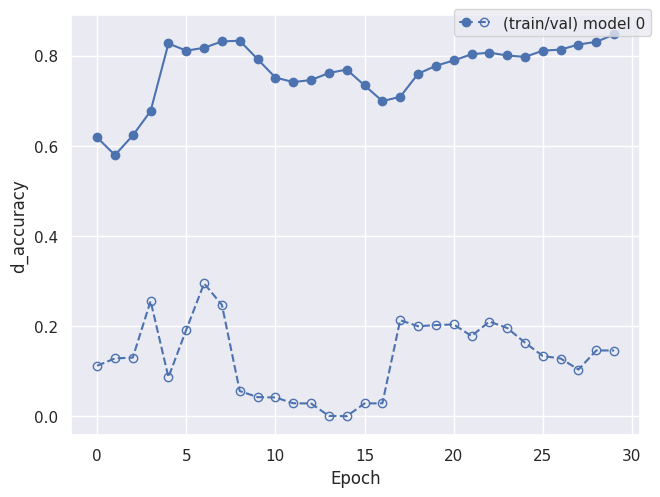

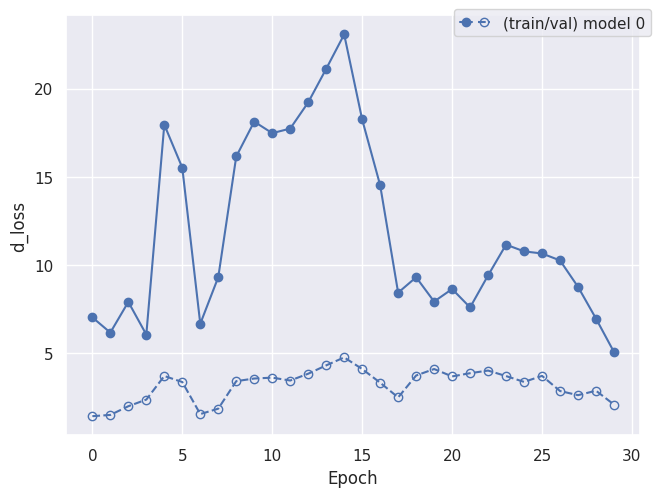

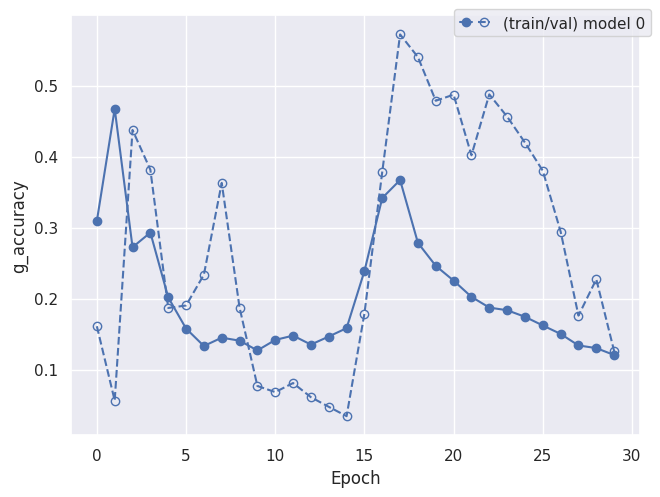

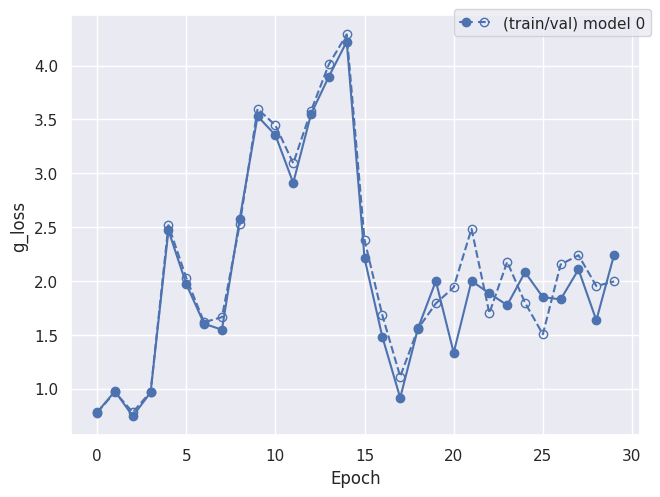

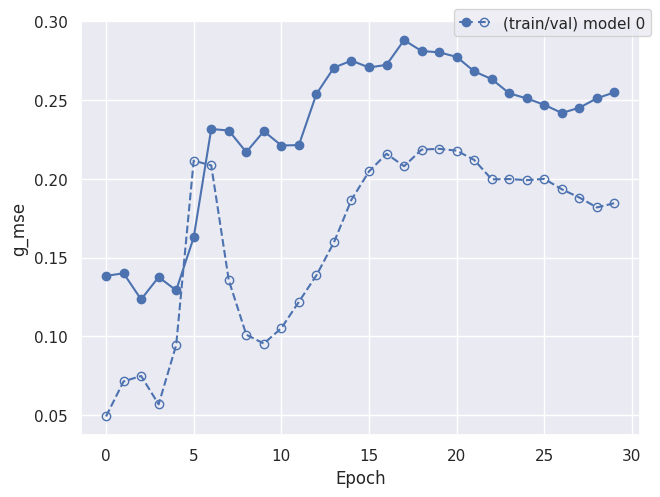

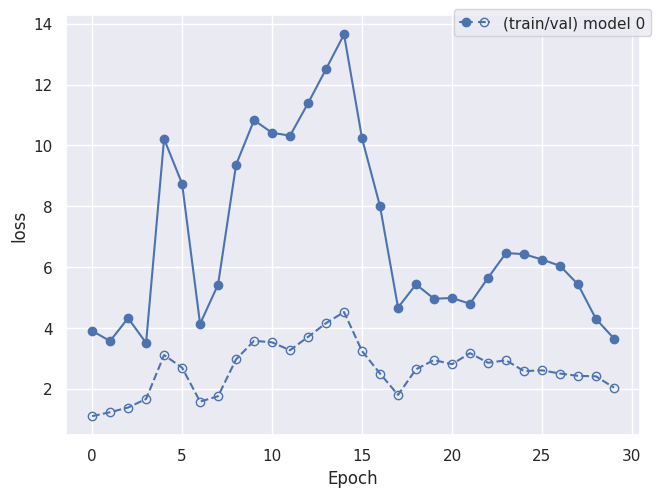

In [24]:
window_len = 24 # Length of input data time windows.
# window_len = 300 # Length of input data time windows.
feat_len = 2 # Number of input feature dimensions.
batch_size = 64
# epochs = 3
# epochs = 10
epochs = 30

hparams = dict(
    window_len=[window_len],
    feat_len=[feat_len],
    # latent_dim=[2*feat_len, 3*feat_len, 4*feat_len],
    # latent_dim=[2*feat_len],
    latent_dim=[
        128,
        # 256,
    ], # Force latent dim to be same as input features.
    k=[
        5,
        # 10,
        # 50, # Very slow
    ],

    # Discriminator parameters.
    D_model_type=['rnn'],
    D_n_layers=[
        3,
        # 6,
    ],
    D_hidden_units=[
        24,
        # 72,
        ],
    D_layer_type=['gru'],

    # Generator parameters.
    G_model_type=['rnn'],
    G_n_layers=[
        3,
        # 6,
    ],
    G_hidden_units=[
        24,
        # 72,
        ],
    G_layer_type=['gru'],


    # lr=[1e-3, 1e-4],
    # lr=[1e-3],
    lr=[1e-4],
    # lr=[5e-4],
    # lr=[5e-3],
    beta_1=[0.5],
    beta_2=[0.9],
    optim=['adam'],
)

# Create loading wrapper for 16-QAM dataset.
dataset_loader_func = dataset_loader_wrapper(
    path=roots['dataset']/"16-qam",
    feat_len=feat_len,
    window_len=window_len,
    split=[.7, .2, .1],
    shuffle=False,
)

# Create build/compile wrapper for GAN model.
build_model_func = build_binary_gan_wrapper(
)

# Hyperparameter tuning.
model, hist, met, params, df, histories = hypertune(
    hparams=hparams,
    build_model_func=build_model_func,
    dataset_loader_func=dataset_loader_func,
    epochs=epochs,
    batch_size=batch_size,
    tuning_root=roots["tuning"]/f"gan-test-k=5-noisyinput-bceloss-nomodelcall",
)



model.discriminator.summary()
model.generator.summary()

plot_hypertune_histories(histories)

2022-12-03 14:18:47.815557: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(1, 24, 2)


2022-12-03 14:18:48.250698: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100


(1, 24, 2)


<Figure size 640x480 with 0 Axes>

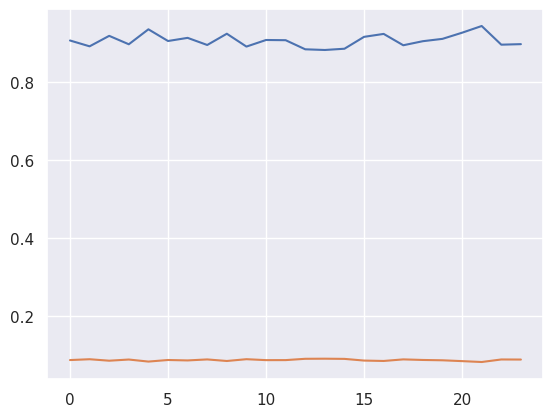

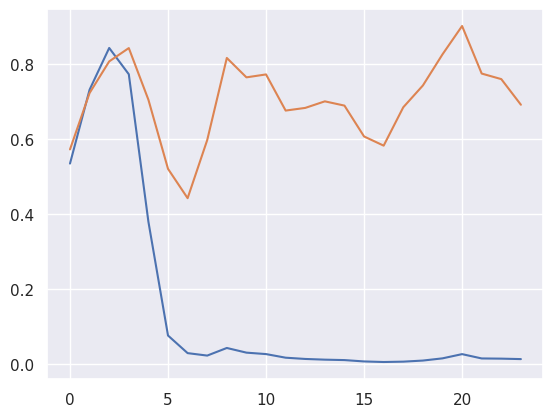

In [25]:
dataset_loader_func = dataset_loader_wrapper(
    path=roots['dataset']/"16-qam",
    feat_len=feat_len,
    window_len=window_len,
    split=[.7, .2, .1],
    shuffle=False,
)

# n = 10_000
n = 1
train, val, test = dataset_loader_func(n)
x_real = next(iter(train))
print(x_real.shape)
# x_fake = model.generator(tf.random.uniform(shape=(*x_real.shape[:-1],128)))
x_fake = model.generator(tf.random.normal(shape=(*x_real.shape[:-1],128)))
# x_fake = model.generator(tf.ones(shape=(*x_real.shape[:-1],128)))
print(x_fake.shape)

plt.figure()
# plt.plot(x_real[-1,:,1], label='real')
# plt.plot(x_fake[-1,:,1], label='fake')
# plt.legend()

plt.figure()
plt.plot(tf.reshape(x_real, shape=(n*window_len, 2))[:,0])
plt.plot(tf.reshape(x_real, shape=(n*window_len, 2))[:,1])

plt.figure()
plt.plot(tf.reshape(x_fake, shape=(n*window_len, 2))[:,0])
plt.plot(tf.reshape(x_fake, shape=(n*window_len, 2))[:,1])

--------

### Tune Everything

In [26]:
window_len = 24 # Length of input data time windows.
# window_len = 300 # Length of input data time windows.
feat_len = 2 # Number of input feature dimensions.
batch_size = 64
# epochs = 3
# epochs = 10
epochs = 30

hparams = dict(
    window_len=[window_len],
    feat_len=[feat_len],
    latent_dim=[128],
    k=[5],

    # Discriminator parameters.
    D_model_type=['rnn'],
    D_n_layers=[
        3,
        6,
    ],
    D_hidden_units=[
        24,
        72,
        ],
    D_layer_type=['gru'],

    # Generator parameters.
    G_model_type=['rnn'],
    G_n_layers=[
        3,
        6,
    ],
    G_hidden_units=[
        24,
        72,
        ],
    G_layer_type=['gru'],


    lr=[1e-3, 1e-4],
    beta_1=[0.5],
    beta_2=[0.9],
    optim=['adam'],
)

# Create loading wrapper for 16-QAM dataset.
dataset_loader_func = dataset_loader_wrapper(
    path=roots['dataset']/"16-qam",
    feat_len=feat_len,
    window_len=window_len,
    split=[.7, .2, .1],
    shuffle=False,
)

# Create build/compile wrapper for GAN model.
build_model_func = build_binary_gan_wrapper(
)

# Hyperparameter tuning.
model, hist, met, params, df, histories = hypertune(
    hparams=hparams,
    build_model_func=build_model_func,
    dataset_loader_func=dataset_loader_func,
    epochs=epochs,
    batch_size=batch_size,
    tuning_root=roots["tuning"]/f"gan-hypertune",
)

Evaluating 32 hyperparameter combinations
[model_0] Parameters: {'D_hidden_units': 24, 'D_layer_type': 'gru', 'D_model_type': 'rnn', 'D_n_layers': 3, 'G_hidden_units': 24, 'G_layer_type': 'gru', 'G_model_type': 'rnn', 'G_n_layers': 3, 'beta_1': 0.5, 'beta_2': 0.9, 'feat_len': 2, 'k': 5, 'latent_dim': 128, 'lr': 0.001, 'optim': 'adam', 'window_len': 24}
[model_0] Training new model: epochs=30, batch_size=64
[model_0] Model building...
[model_0] Model built: {'D_hidden_units': 24, 'D_layer_type': 'gru', 'D_model_type': 'rnn', 'D_n_layers': 3, 'G_hidden_units': 24, 'G_layer_type': 'gru', 'G_model_type': 'rnn', 'G_n_layers': 3, 'beta_1': 0.5, 'beta_2': 0.9, 'feat_len': 2, 'k': 5, 'latent_dim': 128, 'lr': 0.001, 'optim': 'adam', 'window_len': 24}
Epoch 1/30
175/175 [==============================] - 59s 67ms/step - loss: 5.5069 - d_loss: 7.7070 - g_loss: 3.3069 - d_accuracy: 0.8330 - g_accuracy: 0.0865 - g_mse: 0.1752 - val_loss: 3.2905 - val_d_loss: 3.8482 - val_g_loss: 2.7327 - val_d_accu

INFO:tensorflow:Assets written to: tuning/gan-hypertune/model_0/assets


INFO:tensorflow:Assets written to: tuning/gan-hypertune/model_0/assets


50/50 [==============================] - 0s 7ms/step - loss: 4.6360 - d_loss: 3.9632 - g_loss: 5.3089 - d_accuracy: 0.0369 - g_accuracy: 0.0192 - g_mse: 0.2362
[model_0] metrics: {'loss': 2.9636852741241455, 'test_loss': 0.037339694797992706, 'd_loss': 0.5880832672119141, 'test_d_loss': 5.104467391967773, 'g_loss': 5.339287281036377, 'test_g_loss': 0.019797205924987793, 'd_accuracy': 0.9551923871040344, 'test_d_accuracy': 5.3120598793029785, 'g_accuracy': 0.027362961322069168, 'test_g_accuracy': 0.23790545761585236, 'g_mse': 0.2269129753112793, 'test_g_mse': 5.208263397216797, 'val_loss': 4.188546180725098, 'val_d_loss': 2.946486234664917, 'val_g_loss': 5.430606365203857, 'val_d_accuracy': 0.26793166995048523, 'val_g_accuracy': 0.0197443924844265, 'val_g_mse': 0.2398192286491394}
[model_1] Parameters: {'D_hidden_units': 24, 'D_layer_type': 'gru', 'D_model_type': 'rnn', 'D_n_layers': 3, 'G_hidden_units': 24, 'G_layer_type': 'gru', 'G_model_type': 'rnn', 'G_n_layers': 3, 'beta_1': 0.5, '

INFO:tensorflow:Assets written to: tuning/gan-hypertune/model_1/assets


INFO:tensorflow:Assets written to: tuning/gan-hypertune/model_1/assets


50/50 [==============================] - 0s 7ms/step - loss: 3.2636 - d_loss: 2.8117 - g_loss: 3.7155 - d_accuracy: 0.0446 - g_accuracy: 0.1272 - g_mse: 0.0448
[model_1] metrics: {'loss': 3.1148321628570557, 'test_loss': 0.10416015237569809, 'd_loss': 2.62520170211792, 'test_d_loss': 3.094284772872925, 'g_loss': 3.6044626235961914, 'test_g_loss': 0.1292618066072464, 'd_accuracy': 0.890876054763794, 'test_d_accuracy': 3.4952476024627686, 'g_accuracy': 0.06628736853599548, 'test_g_accuracy': 0.060640014708042145, 'g_mse': 0.189220130443573, 'test_g_mse': 3.2947661876678467, 'val_loss': 2.9866323471069336, 'val_d_loss': 2.2553844451904297, 'val_g_loss': 3.7178800106048584, 'val_d_accuracy': 0.27177882194519043, 'val_g_accuracy': 0.13485915958881378, 'val_g_mse': 0.058161716908216476}
[model_2] Parameters: {'D_hidden_units': 24, 'D_layer_type': 'gru', 'D_model_type': 'rnn', 'D_n_layers': 3, 'G_hidden_units': 24, 'G_layer_type': 'gru', 'G_model_type': 'rnn', 'G_n_layers': 6, 'beta_1': 0.5, 

INFO:tensorflow:Assets written to: tuning/gan-hypertune/model_2/assets


INFO:tensorflow:Assets written to: tuning/gan-hypertune/model_2/assets


50/50 [==============================] - 0s 8ms/step - loss: 4.3660 - d_loss: 2.0098 - g_loss: 6.7222 - d_accuracy: 0.9494 - g_accuracy: 0.0255 - g_mse: 0.2928
[model_2] metrics: {'loss': 3.6717796325683594, 'test_loss': 0.745607852935791, 'd_loss': 0.5054677128791809, 'test_d_loss': 6.169724464416504, 'g_loss': 6.8380913734436035, 'test_g_loss': 0.025609947741031647, 'd_accuracy': 0.9674729704856873, 'test_d_accuracy': 6.763433933258057, 'g_accuracy': 0.020347103476524353, 'test_g_accuracy': 0.28898894786834717, 'g_mse': 0.29292598366737366, 'test_g_mse': 6.466579437255859, 'val_loss': 3.3654229640960693, 'val_d_loss': 0.07138912379741669, 'val_g_loss': 6.659456729888916, 'val_d_accuracy': 0.9891366958618164, 'val_g_accuracy': 0.025925925001502037, 'val_g_mse': 0.29028061032295227}
[model_3] Parameters: {'D_hidden_units': 24, 'D_layer_type': 'gru', 'D_model_type': 'rnn', 'D_n_layers': 3, 'G_hidden_units': 24, 'G_layer_type': 'gru', 'G_model_type': 'rnn', 'G_n_layers': 6, 'beta_1': 0.5

INFO:tensorflow:Assets written to: tuning/gan-hypertune/model_3/assets


INFO:tensorflow:Assets written to: tuning/gan-hypertune/model_3/assets


50/50 [==============================] - 0s 8ms/step - loss: 1.0738 - d_loss: 1.4038 - g_loss: 0.7437 - d_accuracy: 0.9321 - g_accuracy: 0.6627 - g_mse: 0.1338
[model_3] metrics: {'loss': 4.596316337585449, 'test_loss': 0.778333842754364, 'd_loss': 8.470355033874512, 'test_d_loss': 1.8279657363891602, 'g_loss': 0.7222775220870972, 'test_g_loss': 0.6600980162620544, 'd_accuracy': 0.8344101309776306, 'test_d_accuracy': 0.7780091166496277, 'g_accuracy': 0.07182405143976212, 'test_g_accuracy': 0.10808554291725159, 'g_mse': 0.20816972851753235, 'test_g_mse': 1.3029874563217163, 'val_loss': 1.00222909450531, 'val_d_loss': 1.2814300060272217, 'val_g_loss': 0.7230281233787537, 'val_d_accuracy': 0.8687663078308105, 'val_g_accuracy': 0.6573943495750427, 'val_g_mse': 0.12315525114536285}
[model_4] Parameters: {'D_hidden_units': 24, 'D_layer_type': 'gru', 'D_model_type': 'rnn', 'D_n_layers': 3, 'G_hidden_units': 72, 'G_layer_type': 'gru', 'G_model_type': 'rnn', 'G_n_layers': 3, 'beta_1': 0.5, 'bet

INFO:tensorflow:Assets written to: tuning/gan-hypertune/model_4/assets


INFO:tensorflow:Assets written to: tuning/gan-hypertune/model_4/assets


50/50 [==============================] - 0s 7ms/step - loss: 5.3027 - d_loss: 4.1014 - g_loss: 6.5041 - d_accuracy: 0.0273 - g_accuracy: 0.0120 - g_mse: 0.3088
[model_4] metrics: {'loss': 3.3724169731140137, 'test_loss': 0.022482015192508698, 'd_loss': 0.2764567732810974, 'test_d_loss': 4.688577651977539, 'g_loss': 6.468377113342285, 'test_g_loss': 0.011677614413201809, 'd_accuracy': 0.9449629783630371, 'test_d_accuracy': 6.455502986907959, 'g_accuracy': 0.03137574717402458, 'test_g_accuracy': 0.3201110363006592, 'g_mse': 0.24971744418144226, 'test_g_mse': 5.572040557861328, 'val_loss': 5.626608371734619, 'val_d_loss': 4.60831880569458, 'val_g_loss': 6.644897937774658, 'val_d_accuracy': 0.27155712246894836, 'val_g_accuracy': 0.01068075094372034, 'val_g_mse': 0.3135322034358978}
[model_5] Parameters: {'D_hidden_units': 24, 'D_layer_type': 'gru', 'D_model_type': 'rnn', 'D_n_layers': 3, 'G_hidden_units': 72, 'G_layer_type': 'gru', 'G_model_type': 'rnn', 'G_n_layers': 3, 'beta_1': 0.5, 'be

INFO:tensorflow:Assets written to: tuning/gan-hypertune/model_5/assets


INFO:tensorflow:Assets written to: tuning/gan-hypertune/model_5/assets


50/50 [==============================] - 0s 7ms/step - loss: 1.7842 - d_loss: 2.4267 - g_loss: 1.1417 - d_accuracy: 0.0704 - g_accuracy: 0.1940 - g_mse: 0.2481
[model_5] metrics: {'loss': 6.163823127746582, 'test_loss': 0.08846835792064667, 'd_loss': 11.170913696289062, 'test_d_loss': 2.6267502307891846, 'g_loss': 1.1567329168319702, 'test_g_loss': 0.1904650181531906, 'd_accuracy': 0.7044099569320679, 'test_d_accuracy': 1.1520038843154907, 'g_accuracy': 0.19473382830619812, 'test_g_accuracy': 0.2694791555404663, 'g_mse': 0.3050772249698639, 'test_g_mse': 1.8893771171569824, 'val_loss': 1.6998987197875977, 'val_d_loss': 2.2602288722991943, 'val_g_loss': 1.139568567276001, 'val_d_accuracy': 0.07198747992515564, 'val_g_accuracy': 0.19037558138370514, 'val_g_mse': 0.2601170539855957}
[model_6] Parameters: {'D_hidden_units': 24, 'D_layer_type': 'gru', 'D_model_type': 'rnn', 'D_n_layers': 3, 'G_hidden_units': 72, 'G_layer_type': 'gru', 'G_model_type': 'rnn', 'G_n_layers': 6, 'beta_1': 0.5, '

INFO:tensorflow:Assets written to: tuning/gan-hypertune/model_6/assets


INFO:tensorflow:Assets written to: tuning/gan-hypertune/model_6/assets


50/50 [==============================] - 0s 8ms/step - loss: 3.7589 - d_loss: 3.8851 - g_loss: 3.6327 - d_accuracy: 0.0482 - g_accuracy: 0.0470 - g_mse: 0.2245
[model_6] metrics: {'loss': 3.635801076889038, 'test_loss': 0.24128088355064392, 'd_loss': 3.1769518852233887, 'test_d_loss': 0.8168277740478516, 'g_loss': 4.0946502685546875, 'test_g_loss': 0.04719268158078194, 'd_accuracy': 0.9305046200752258, 'test_d_accuracy': 3.6514198780059814, 'g_accuracy': 0.04502369835972786, 'test_g_accuracy': 0.24767352640628815, 'g_mse': 0.27616918087005615, 'test_g_mse': 2.234123706817627, 'val_loss': 4.386347770690918, 'val_d_loss': 4.934263706207275, 'val_g_loss': 3.8384320735931396, 'val_d_accuracy': 0.22009649872779846, 'val_g_accuracy': 0.04681794345378876, 'val_g_mse': 0.23696406185626984}
[model_7] Parameters: {'D_hidden_units': 24, 'D_layer_type': 'gru', 'D_model_type': 'rnn', 'D_n_layers': 3, 'G_hidden_units': 72, 'G_layer_type': 'gru', 'G_model_type': 'rnn', 'G_n_layers': 6, 'beta_1': 0.5,

INFO:tensorflow:Assets written to: tuning/gan-hypertune/model_7/assets


INFO:tensorflow:Assets written to: tuning/gan-hypertune/model_7/assets


50/50 [==============================] - 0s 8ms/step - loss: 1.2660 - d_loss: 1.5848 - g_loss: 0.9472 - d_accuracy: 0.0000e+00 - g_accuracy: 0.0000e+00 - g_mse: 0.3222
[model_7] metrics: {'loss': 4.349817752838135, 'test_loss': 0.0, 'd_loss': 7.748422145843506, 'test_d_loss': 1.6877472400665283, 'g_loss': 0.951213002204895, 'test_g_loss': 0.0, 'd_accuracy': 0.6537378430366516, 'test_d_accuracy': 0.9469684362411499, 'g_accuracy': 0.274143785238266, 'test_g_accuracy': 0.3061354160308838, 'g_mse': 0.30949637293815613, 'test_g_mse': 1.3173577785491943, 'val_loss': 1.2380712032318115, 'val_d_loss': 1.5296850204467773, 'val_g_loss': 0.9464573264122009, 'val_d_accuracy': 0.0, 'val_g_accuracy': 0.0, 'val_g_mse': 0.31334641575813293}
[model_8] Parameters: {'D_hidden_units': 24, 'D_layer_type': 'gru', 'D_model_type': 'rnn', 'D_n_layers': 6, 'G_hidden_units': 24, 'G_layer_type': 'gru', 'G_model_type': 'rnn', 'G_n_layers': 3, 'beta_1': 0.5, 'beta_2': 0.9, 'feat_len': 2, 'k': 5, 'latent_dim': 128, 

INFO:tensorflow:Assets written to: tuning/gan-hypertune/model_8/assets


INFO:tensorflow:Assets written to: tuning/gan-hypertune/model_8/assets


50/50 [==============================] - 0s 9ms/step - loss: 5.2398 - d_loss: 3.9863 - g_loss: 6.4933 - d_accuracy: 0.1044 - g_accuracy: 0.0043 - g_mse: 0.2020
[model_8] metrics: {'loss': 3.2658047676086426, 'test_loss': 0.11251433938741684, 'd_loss': 0.07883147895336151, 'test_d_loss': 7.042721271514893, 'g_loss': 6.452777862548828, 'test_g_loss': 0.0040923780761659145, 'd_accuracy': 0.9829056262969971, 'test_d_accuracy': 6.395209789276123, 'g_accuracy': 0.014221735298633575, 'test_g_accuracy': 0.21141037344932556, 'g_mse': 0.22741098701953888, 'test_g_mse': 6.718965530395508, 'val_loss': 4.218006134033203, 'val_d_loss': 1.6648975610733032, 'val_g_loss': 6.771114826202393, 'val_d_accuracy': 0.3158450722694397, 'val_g_accuracy': 0.004851330071687698, 'val_g_mse': 0.20911796391010284}
[model_9] Parameters: {'D_hidden_units': 24, 'D_layer_type': 'gru', 'D_model_type': 'rnn', 'D_n_layers': 6, 'G_hidden_units': 24, 'G_layer_type': 'gru', 'G_model_type': 'rnn', 'G_n_layers': 3, 'beta_1': 0.

INFO:tensorflow:Assets written to: tuning/gan-hypertune/model_9/assets


INFO:tensorflow:Assets written to: tuning/gan-hypertune/model_9/assets


50/50 [==============================] - 0s 10ms/step - loss: 1.1650 - d_loss: 1.0357 - g_loss: 1.2944 - d_accuracy: 0.9279 - g_accuracy: 0.2007 - g_mse: 0.1171
[model_9] metrics: {'loss': 4.171592712402344, 'test_loss': 0.8788577914237976, 'd_loss': 6.969466209411621, 'test_d_loss': 1.137347936630249, 'g_loss': 1.3737188577651978, 'test_g_loss': 0.20192107558250427, 'd_accuracy': 0.8979719877243042, 'test_d_accuracy': 1.3162647485733032, 'g_accuracy': 0.060027871280908585, 'test_g_accuracy': 0.09963230043649673, 'g_mse': 0.2179451435804367, 'test_g_mse': 1.226806402206421, 'val_loss': 1.2285747528076172, 'val_d_loss': 1.1409695148468018, 'val_g_loss': 1.3161799907684326, 'val_d_accuracy': 0.8839332461357117, 'val_g_accuracy': 0.1934402734041214, 'val_g_mse': 0.11150316148996353}
[model_10] Parameters: {'D_hidden_units': 24, 'D_layer_type': 'gru', 'D_model_type': 'rnn', 'D_n_layers': 6, 'G_hidden_units': 24, 'G_layer_type': 'gru', 'G_model_type': 'rnn', 'G_n_layers': 6, 'beta_1': 0.5, 

INFO:tensorflow:Assets written to: tuning/gan-hypertune/model_10/assets


INFO:tensorflow:Assets written to: tuning/gan-hypertune/model_10/assets


50/50 [==============================] - 1s 12ms/step - loss: 2.8024 - d_loss: 2.5255 - g_loss: 3.0792 - d_accuracy: 0.4260 - g_accuracy: 0.0982 - g_mse: 0.1833
[model_10] metrics: {'loss': 2.425417423248291, 'test_loss': 0.3892842233181, 'd_loss': 1.372688889503479, 'test_d_loss': 4.126793384552002, 'g_loss': 3.4781460762023926, 'test_g_loss': 0.10065425932407379, 'd_accuracy': 0.9686819911003113, 'test_d_accuracy': 3.2323508262634277, 'g_accuracy': 0.019478971138596535, 'test_g_accuracy': 0.1696314662694931, 'g_mse': 0.25151506066322327, 'test_g_mse': 3.679572105407715, 'val_loss': 2.0421524047851562, 'val_d_loss': 1.1508781909942627, 'val_g_loss': 2.933426856994629, 'val_d_accuracy': 0.515088677406311, 'val_g_accuracy': 0.10568596422672272, 'val_g_mse': 0.17253170907497406}
[model_11] Parameters: {'D_hidden_units': 24, 'D_layer_type': 'gru', 'D_model_type': 'rnn', 'D_n_layers': 6, 'G_hidden_units': 24, 'G_layer_type': 'gru', 'G_model_type': 'rnn', 'G_n_layers': 6, 'beta_1': 0.5, 'be

INFO:tensorflow:Assets written to: tuning/gan-hypertune/model_11/assets


INFO:tensorflow:Assets written to: tuning/gan-hypertune/model_11/assets


50/50 [==============================] - 1s 11ms/step - loss: 3.4562 - d_loss: 0.0109 - g_loss: 6.9014 - d_accuracy: 1.0000 - g_accuracy: 0.0011 - g_mse: 0.1004
[model_11] metrics: {'loss': 3.717057228088379, 'test_loss': 1.0, 'd_loss': 0.5178605318069458, 'test_d_loss': 0.004397169686853886, 'g_loss': 6.916254043579102, 'test_g_loss': 0.0011599416611716151, 'd_accuracy': 0.862531304359436, 'test_d_accuracy': 6.8868513107299805, 'g_accuracy': 0.08738338202238083, 'test_g_accuracy': 0.07991011440753937, 'g_mse': 0.23725244402885437, 'test_g_mse': 3.445624351501465, 'val_loss': 3.4512593746185303, 'val_d_loss': 0.1172763779759407, 'val_g_loss': 6.785242557525635, 'val_d_accuracy': 0.9937663078308105, 'val_g_accuracy': 0.0021909233182668686, 'val_g_mse': 0.09302712231874466}
[model_12] Parameters: {'D_hidden_units': 24, 'D_layer_type': 'gru', 'D_model_type': 'rnn', 'D_n_layers': 6, 'G_hidden_units': 72, 'G_layer_type': 'gru', 'G_model_type': 'rnn', 'G_n_layers': 3, 'beta_1': 0.5, 'beta_2'

INFO:tensorflow:Assets written to: tuning/gan-hypertune/model_12/assets


INFO:tensorflow:Assets written to: tuning/gan-hypertune/model_12/assets


50/50 [==============================] - 1s 10ms/step - loss: 5.1389 - d_loss: 4.4390 - g_loss: 5.8389 - d_accuracy: 0.0310 - g_accuracy: 0.0467 - g_mse: 0.2844
[model_12] metrics: {'loss': 4.085346221923828, 'test_loss': 0.0474403090775013, 'd_loss': 2.1396989822387695, 'test_d_loss': 5.49697208404541, 'g_loss': 6.030993938446045, 'test_g_loss': 0.046475861221551895, 'd_accuracy': 0.9776260256767273, 'test_d_accuracy': 5.92029333114624, 'g_accuracy': 0.015358133241534233, 'test_g_accuracy': 0.29171252250671387, 'g_mse': 0.2083873748779297, 'test_g_mse': 5.708632469177246, 'val_loss': 3.6622045040130615, 'val_d_loss': 1.4775829315185547, 'val_g_loss': 5.846826076507568, 'val_d_accuracy': 0.2503260374069214, 'val_g_accuracy': 0.04529212415218353, 'val_g_mse': 0.28948426246643066}
[model_13] Parameters: {'D_hidden_units': 24, 'D_layer_type': 'gru', 'D_model_type': 'rnn', 'D_n_layers': 6, 'G_hidden_units': 72, 'G_layer_type': 'gru', 'G_model_type': 'rnn', 'G_n_layers': 3, 'beta_1': 0.5, '

INFO:tensorflow:Assets written to: tuning/gan-hypertune/model_13/assets


INFO:tensorflow:Assets written to: tuning/gan-hypertune/model_13/assets


50/50 [==============================] - 0s 10ms/step - loss: 3.2692 - d_loss: 3.9267 - g_loss: 2.6116 - d_accuracy: 0.0100 - g_accuracy: 0.0941 - g_mse: 0.1427
[model_13] metrics: {'loss': 9.354329109191895, 'test_loss': 0.002867271425202489, 'd_loss': 16.04271697998047, 'test_d_loss': 3.512211561203003, 'g_loss': 2.6659419536590576, 'test_g_loss': 0.09188301861286163, 'd_accuracy': 0.8587793111801147, 'test_d_accuracy': 2.6476492881774902, 'g_accuracy': 0.05672300234436989, 'test_g_accuracy': 0.15522074699401855, 'g_mse': 0.21126991510391235, 'test_g_mse': 3.079930305480957, 'val_loss': 3.3382725715637207, 'val_d_loss': 4.1517229080200195, 'val_g_loss': 2.5248219966888428, 'val_d_accuracy': 0.013041210360825062, 'val_g_accuracy': 0.0917057916522026, 'val_g_mse': 0.14753538370132446}
[model_14] Parameters: {'D_hidden_units': 24, 'D_layer_type': 'gru', 'D_model_type': 'rnn', 'D_n_layers': 6, 'G_hidden_units': 72, 'G_layer_type': 'gru', 'G_model_type': 'rnn', 'G_n_layers': 6, 'beta_1': 

INFO:tensorflow:Assets written to: tuning/gan-hypertune/model_14/assets


INFO:tensorflow:Assets written to: tuning/gan-hypertune/model_14/assets


50/50 [==============================] - 1s 11ms/step - loss: 2.5469 - d_loss: 0.5101 - g_loss: 4.5837 - d_accuracy: 0.8544 - g_accuracy: 0.0137 - g_mse: 0.3135
[model_14] metrics: {'loss': 3.461087465286255, 'test_loss': 0.8762120604515076, 'd_loss': 2.04311466217041, 'test_d_loss': 0.3521048426628113, 'g_loss': 4.8790602684021, 'test_g_loss': 0.012238035909831524, 'd_accuracy': 0.9742540717124939, 'test_d_accuracy': 4.698709964752197, 'g_accuracy': 0.025313720107078552, 'test_g_accuracy': 0.3143194913864136, 'g_mse': 0.29506510496139526, 'test_g_mse': 2.525407314300537, 'val_loss': 2.5738351345062256, 'val_d_loss': 0.4049178957939148, 'val_g_loss': 4.742752552032471, 'val_d_accuracy': 0.8731090426445007, 'val_g_accuracy': 0.01332811638712883, 'val_g_mse': 0.3125743567943573}
[model_15] Parameters: {'D_hidden_units': 24, 'D_layer_type': 'gru', 'D_model_type': 'rnn', 'D_n_layers': 6, 'G_hidden_units': 72, 'G_layer_type': 'gru', 'G_model_type': 'rnn', 'G_n_layers': 6, 'beta_1': 0.5, 'be

INFO:tensorflow:Assets written to: tuning/gan-hypertune/model_15/assets


INFO:tensorflow:Assets written to: tuning/gan-hypertune/model_15/assets


50/50 [==============================] - 1s 12ms/step - loss: 2.3184 - d_loss: 2.7998 - g_loss: 1.8369 - d_accuracy: 0.0100 - g_accuracy: 0.1788 - g_mse: 0.2143
[model_15] metrics: {'loss': 6.2464776039123535, 'test_loss': 0.002867271425202489, 'd_loss': 10.752721786499023, 'test_d_loss': 2.621290922164917, 'g_loss': 1.7402337789535522, 'test_g_loss': 0.17839641869068146, 'd_accuracy': 0.7921901345252991, 'test_d_accuracy': 1.7957837581634521, 'g_accuracy': 0.1615361124277115, 'test_g_accuracy': 0.21742399036884308, 'g_mse': 0.2407042235136032, 'test_g_mse': 2.2085373401641846, 'val_loss': 2.178755283355713, 'val_d_loss': 2.663695812225342, 'val_g_loss': 1.6938148736953735, 'val_d_accuracy': 0.013041210360825062, 'val_g_accuracy': 0.17836463451385498, 'val_g_mse': 0.2156979739665985}
[model_16] Parameters: {'D_hidden_units': 72, 'D_layer_type': 'gru', 'D_model_type': 'rnn', 'D_n_layers': 3, 'G_hidden_units': 24, 'G_layer_type': 'gru', 'G_model_type': 'rnn', 'G_n_layers': 3, 'beta_1': 0

INFO:tensorflow:Assets written to: tuning/gan-hypertune/model_16/assets


INFO:tensorflow:Assets written to: tuning/gan-hypertune/model_16/assets


50/50 [==============================] - 0s 7ms/step - loss: 5.7481 - d_loss: 3.8929 - g_loss: 7.6032 - d_accuracy: 0.1379 - g_accuracy: 0.0047 - g_mse: 0.2265
[model_16] metrics: {'loss': 3.975911855697632, 'test_loss': 0.21126577258110046, 'd_loss': 0.20843984186649323, 'test_d_loss': 5.770973205566406, 'g_loss': 7.743383884429932, 'test_g_loss': 0.0046527995727956295, 'd_accuracy': 0.9804483652114868, 'test_d_accuracy': 7.458763122558594, 'g_accuracy': 0.014117410406470299, 'test_g_accuracy': 0.23129110038280487, 'g_mse': 0.2151360809803009, 'test_g_mse': 6.6148681640625, 'val_loss': 4.0136308670043945, 'val_d_loss': 0.6176488995552063, 'val_g_loss': 7.409612655639648, 'val_d_accuracy': 0.3359155058860779, 'val_g_accuracy': 0.004747000522911549, 'val_g_mse': 0.2277626246213913}
[model_17] Parameters: {'D_hidden_units': 72, 'D_layer_type': 'gru', 'D_model_type': 'rnn', 'D_n_layers': 3, 'G_hidden_units': 24, 'G_layer_type': 'gru', 'G_model_type': 'rnn', 'G_n_layers': 3, 'beta_1': 0.5,

INFO:tensorflow:Assets written to: tuning/gan-hypertune/model_17/assets


INFO:tensorflow:Assets written to: tuning/gan-hypertune/model_17/assets


50/50 [==============================] - 0s 7ms/step - loss: 5.1796 - d_loss: 3.7006 - g_loss: 6.6586 - d_accuracy: 0.5845 - g_accuracy: 0.0156 - g_mse: 0.1294
[model_17] metrics: {'loss': 5.930273056030273, 'test_loss': 0.5199405550956726, 'd_loss': 5.23651647567749, 'test_d_loss': 8.164247512817383, 'g_loss': 6.624030113220215, 'test_g_loss': 0.01673443801701069, 'd_accuracy': 0.9459689855575562, 'test_d_accuracy': 6.787067413330078, 'g_accuracy': 0.02870800904929638, 'test_g_accuracy': 0.1424885094165802, 'g_mse': 0.2767009139060974, 'test_g_mse': 7.4756574630737305, 'val_loss': 3.563485622406006, 'val_d_loss': 0.8741762042045593, 'val_g_loss': 6.252795219421387, 'val_d_accuracy': 0.5712571740150452, 'val_g_accuracy': 0.016927490010857582, 'val_g_mse': 0.14266693592071533}
[model_18] Parameters: {'D_hidden_units': 72, 'D_layer_type': 'gru', 'D_model_type': 'rnn', 'D_n_layers': 3, 'G_hidden_units': 24, 'G_layer_type': 'gru', 'G_model_type': 'rnn', 'G_n_layers': 6, 'beta_1': 0.5, 'bet

INFO:tensorflow:Assets written to: tuning/gan-hypertune/model_18/assets


INFO:tensorflow:Assets written to: tuning/gan-hypertune/model_18/assets


50/50 [==============================] - 0s 9ms/step - loss: 3.4847 - d_loss: 2.0716 - g_loss: 4.8978 - d_accuracy: 0.6436 - g_accuracy: 0.0370 - g_mse: 0.2324
[model_18] metrics: {'loss': 3.1142578125, 'test_loss': 0.5742623209953308, 'd_loss': 0.9399111270904541, 'test_d_loss': 5.079378128051758, 'g_loss': 5.288604736328125, 'test_g_loss': 0.03693566843867302, 'd_accuracy': 0.9791666865348816, 'test_d_accuracy': 4.990171909332275, 'g_accuracy': 0.01676279492676258, 'test_g_accuracy': 0.24696393311023712, 'g_mse': 0.2277737408876419, 'test_g_mse': 5.0347747802734375, 'val_loss': 2.4755609035491943, 'val_d_loss': 0.19476407766342163, 'val_g_loss': 4.756357669830322, 'val_d_accuracy': 0.6409754753112793, 'val_g_accuracy': 0.03708920255303383, 'val_g_mse': 0.24045798182487488}
[model_19] Parameters: {'D_hidden_units': 72, 'D_layer_type': 'gru', 'D_model_type': 'rnn', 'D_n_layers': 3, 'G_hidden_units': 24, 'G_layer_type': 'gru', 'G_model_type': 'rnn', 'G_n_layers': 6, 'beta_1': 0.5, 'beta

INFO:tensorflow:Assets written to: tuning/gan-hypertune/model_19/assets


INFO:tensorflow:Assets written to: tuning/gan-hypertune/model_19/assets


50/50 [==============================] - 0s 9ms/step - loss: 2.0456 - d_loss: 1.0862 - g_loss: 3.0050 - d_accuracy: 0.7979 - g_accuracy: 0.1761 - g_mse: 0.2931
[model_19] metrics: {'loss': 7.145790100097656, 'test_loss': 0.7527369260787964, 'd_loss': 11.892292022705078, 'test_d_loss': 1.0170238018035889, 'g_loss': 2.3992881774902344, 'test_g_loss': 0.1758158653974533, 'd_accuracy': 0.9252269268035889, 'test_d_accuracy': 2.7144925594329834, 'g_accuracy': 0.04389847815036774, 'test_g_accuracy': 0.3088955581188202, 'g_mse': 0.3291252851486206, 'test_g_mse': 1.8657581806182861, 'val_loss': 2.363328456878662, 'val_d_loss': 1.744943380355835, 'val_g_loss': 2.9817135334014893, 'val_d_accuracy': 0.7668883800506592, 'val_g_accuracy': 0.17087897658348083, 'val_g_mse': 0.3068751394748688}
[model_20] Parameters: {'D_hidden_units': 72, 'D_layer_type': 'gru', 'D_model_type': 'rnn', 'D_n_layers': 3, 'G_hidden_units': 72, 'G_layer_type': 'gru', 'G_model_type': 'rnn', 'G_n_layers': 3, 'beta_1': 0.5, 'b

INFO:tensorflow:Assets written to: tuning/gan-hypertune/model_20/assets


INFO:tensorflow:Assets written to: tuning/gan-hypertune/model_20/assets


50/50 [==============================] - 0s 7ms/step - loss: 6.4525 - d_loss: 4.0857 - g_loss: 8.8192 - d_accuracy: 0.6993 - g_accuracy: 0.0020 - g_mse: 0.2062
[model_20] metrics: {'loss': 4.4694976806640625, 'test_loss': 0.621872067451477, 'd_loss': 0.039254434406757355, 'test_d_loss': 10.808018684387207, 'g_loss': 8.899741172790527, 'test_g_loss': 0.002424147678539157, 'd_accuracy': 0.9897258281707764, 'test_d_accuracy': 8.767989158630371, 'g_accuracy': 0.004146919585764408, 'test_g_accuracy': 0.21080265939235687, 'g_mse': 0.33860865235328674, 'test_g_mse': 9.788003921508789, 'val_loss': 4.343501567840576, 'val_d_loss': 0.042950086295604706, 'val_g_loss': 8.64405345916748, 'val_d_accuracy': 0.6851851940155029, 'val_g_accuracy': 0.002947313478216529, 'val_g_mse': 0.21055948734283447}
[model_21] Parameters: {'D_hidden_units': 72, 'D_layer_type': 'gru', 'D_model_type': 'rnn', 'D_n_layers': 3, 'G_hidden_units': 72, 'G_layer_type': 'gru', 'G_model_type': 'rnn', 'G_n_layers': 3, 'beta_1': 

INFO:tensorflow:Assets written to: tuning/gan-hypertune/model_21/assets


INFO:tensorflow:Assets written to: tuning/gan-hypertune/model_21/assets


50/50 [==============================] - 0s 7ms/step - loss: 4.8000 - d_loss: 4.1196 - g_loss: 5.4803 - d_accuracy: 0.0126 - g_accuracy: 0.0671 - g_mse: 0.2509
[model_21] metrics: {'loss': 3.520676851272583, 'test_loss': 0.015548430383205414, 'd_loss': 1.2290581464767456, 'test_d_loss': 3.5303049087524414, 'g_loss': 5.812295436859131, 'test_g_loss': 0.06554321944713593, 'd_accuracy': 0.9129817485809326, 'test_d_accuracy': 5.435115814208984, 'g_accuracy': 0.07970431447029114, 'test_g_accuracy': 0.2602720856666565, 'g_mse': 0.3131280541419983, 'test_g_mse': 4.482710361480713, 'val_loss': 4.811007976531982, 'val_d_loss': 3.816848039627075, 'val_g_loss': 5.8051676750183105, 'val_d_accuracy': 0.2478351593017578, 'val_g_accuracy': 0.06504955887794495, 'val_g_mse': 0.2533757984638214}
[model_22] Parameters: {'D_hidden_units': 72, 'D_layer_type': 'gru', 'D_model_type': 'rnn', 'D_n_layers': 3, 'G_hidden_units': 72, 'G_layer_type': 'gru', 'G_model_type': 'rnn', 'G_n_layers': 6, 'beta_1': 0.5, 'b

INFO:tensorflow:Assets written to: tuning/gan-hypertune/model_22/assets


INFO:tensorflow:Assets written to: tuning/gan-hypertune/model_22/assets


50/50 [==============================] - 0s 9ms/step - loss: 4.5540 - d_loss: 2.1189 - g_loss: 6.9891 - d_accuracy: 0.6697 - g_accuracy: 0.0227 - g_mse: 0.2787
[model_22] metrics: {'loss': 3.8812618255615234, 'test_loss': 0.5999765396118164, 'd_loss': 0.5236854553222656, 'test_d_loss': 4.894742488861084, 'g_loss': 7.238838195800781, 'test_g_loss': 0.022912105545401573, 'd_accuracy': 0.979034423828125, 'test_d_accuracy': 6.819187641143799, 'g_accuracy': 0.027869682759046555, 'test_g_accuracy': 0.32302552461624146, 'g_mse': 0.25428685545921326, 'test_g_mse': 5.856965065002441, 'val_loss': 3.539886236190796, 'val_d_loss': 0.10748200118541718, 'val_g_loss': 6.972290515899658, 'val_d_accuracy': 0.6679838299751282, 'val_g_accuracy': 0.024178404361009598, 'val_g_mse': 0.30507323145866394}
[model_23] Parameters: {'D_hidden_units': 72, 'D_layer_type': 'gru', 'D_model_type': 'rnn', 'D_n_layers': 3, 'G_hidden_units': 72, 'G_layer_type': 'gru', 'G_model_type': 'rnn', 'G_n_layers': 6, 'beta_1': 0.5

INFO:tensorflow:Assets written to: tuning/gan-hypertune/model_23/assets


INFO:tensorflow:Assets written to: tuning/gan-hypertune/model_23/assets


50/50 [==============================] - 0s 9ms/step - loss: 1.8931 - d_loss: 2.7301 - g_loss: 1.0561 - d_accuracy: 0.1906 - g_accuracy: 0.3313 - g_mse: 0.2062
[model_23] metrics: {'loss': 5.346512317657471, 'test_loss': 0.1930716335773468, 'd_loss': 9.561735153198242, 'test_d_loss': 3.794954299926758, 'g_loss': 1.1312894821166992, 'test_g_loss': 0.3320300281047821, 'd_accuracy': 0.908242404460907, 'test_d_accuracy': 1.0581917762756348, 'g_accuracy': 0.048708606511354446, 'test_g_accuracy': 0.18004824221134186, 'g_mse': 0.2858312129974365, 'test_g_mse': 2.4265730381011963, 'val_loss': 1.5322452783584595, 'val_d_loss': 2.0782394409179688, 'val_g_loss': 0.9862511157989502, 'val_d_accuracy': 0.23021648824214935, 'val_g_accuracy': 0.3353547155857086, 'val_g_mse': 0.19324935972690582}
[model_24] Parameters: {'D_hidden_units': 72, 'D_layer_type': 'gru', 'D_model_type': 'rnn', 'D_n_layers': 6, 'G_hidden_units': 24, 'G_layer_type': 'gru', 'G_model_type': 'rnn', 'G_n_layers': 3, 'beta_1': 0.5, 

INFO:tensorflow:Assets written to: tuning/gan-hypertune/model_24/assets


INFO:tensorflow:Assets written to: tuning/gan-hypertune/model_24/assets


50/50 [==============================] - 1s 10ms/step - loss: 3.8134 - d_loss: 3.5186 - g_loss: 4.1083 - d_accuracy: 4.9447e-04 - g_accuracy: 0.0067 - g_mse: 0.2190
[model_24] metrics: {'loss': 2.6627936363220215, 'test_loss': 0.0007689500343985856, 'd_loss': 1.0857961177825928, 'test_d_loss': 4.963242053985596, 'g_loss': 4.239791393280029, 'test_g_loss': 0.007259409874677658, 'd_accuracy': 0.9909144043922424, 'test_d_accuracy': 3.9440841674804688, 'g_accuracy': 0.008562102913856506, 'test_g_accuracy': 0.22417356073856354, 'g_mse': 0.2862318754196167, 'test_g_mse': 4.453662872314453, 'val_loss': 3.563319206237793, 'val_d_loss': 2.8153555393218994, 'val_g_loss': 4.311282634735107, 'val_d_accuracy': 0.24470527470111847, 'val_g_accuracy': 0.01044600922614336, 'val_g_mse': 0.22740240395069122}
[model_25] Parameters: {'D_hidden_units': 72, 'D_layer_type': 'gru', 'D_model_type': 'rnn', 'D_n_layers': 6, 'G_hidden_units': 24, 'G_layer_type': 'gru', 'G_model_type': 'rnn', 'G_n_layers': 3, 'beta

INFO:tensorflow:Assets written to: tuning/gan-hypertune/model_25/assets


INFO:tensorflow:Assets written to: tuning/gan-hypertune/model_25/assets


50/50 [==============================] - 0s 10ms/step - loss: 5.2958 - d_loss: 0.3652 - g_loss: 10.2263 - d_accuracy: 0.8239 - g_accuracy: 0.0111 - g_mse: 0.1434
[model_25] metrics: {'loss': 5.157464981079102, 'test_loss': 0.8055729269981384, 'd_loss': 0.19179339706897736, 'test_d_loss': 0.02732444368302822, 'g_loss': 10.123136520385742, 'test_g_loss': 0.011012928560376167, 'd_accuracy': 0.9821361899375916, 'test_d_accuracy': 10.635838508605957, 'g_accuracy': 0.01749679632484913, 'test_g_accuracy': 0.14218300580978394, 'g_mse': 0.28197693824768066, 'test_g_mse': 5.3315815925598145, 'val_loss': 5.721824645996094, 'val_d_loss': 0.7711048722267151, 'val_g_loss': 10.672544479370117, 'val_d_accuracy': 0.8905972838401794, 'val_g_accuracy': 0.01011997926980257, 'val_g_mse': 0.14799723029136658}
[model_26] Parameters: {'D_hidden_units': 72, 'D_layer_type': 'gru', 'D_model_type': 'rnn', 'D_n_layers': 6, 'G_hidden_units': 24, 'G_layer_type': 'gru', 'G_model_type': 'rnn', 'G_n_layers': 6, 'beta_1

INFO:tensorflow:Assets written to: tuning/gan-hypertune/model_26/assets


INFO:tensorflow:Assets written to: tuning/gan-hypertune/model_26/assets


50/50 [==============================] - 1s 11ms/step - loss: 5.1487 - d_loss: 3.4534 - g_loss: 6.8441 - d_accuracy: 0.1655 - g_accuracy: 0.0015 - g_mse: 0.1898
[model_26] metrics: {'loss': 3.4143924713134766, 'test_loss': 0.20567458868026733, 'd_loss': 0.048467472195625305, 'test_d_loss': 7.1796159744262695, 'g_loss': 6.780317306518555, 'test_g_loss': 0.0016421645414084196, 'd_accuracy': 0.9937442541122437, 'test_d_accuracy': 6.822459697723389, 'g_accuracy': 0.0069413394667208195, 'test_g_accuracy': 0.20887359976768494, 'g_mse': 0.2984863817691803, 'test_g_mse': 7.00103759765625, 'val_loss': 3.7974636554718018, 'val_d_loss': 0.7213908433914185, 'val_g_loss': 6.873536586761475, 'val_d_accuracy': 0.3510693907737732, 'val_g_accuracy': 0.0014214919647201896, 'val_g_mse': 0.20037227869033813}
[model_27] Parameters: {'D_hidden_units': 72, 'D_layer_type': 'gru', 'D_model_type': 'rnn', 'D_n_layers': 6, 'G_hidden_units': 24, 'G_layer_type': 'gru', 'G_model_type': 'rnn', 'G_n_layers': 6, 'beta_

INFO:tensorflow:Assets written to: tuning/gan-hypertune/model_27/assets


INFO:tensorflow:Assets written to: tuning/gan-hypertune/model_27/assets


50/50 [==============================] - 1s 11ms/step - loss: 8.3315 - d_loss: 1.6154 - g_loss: 15.0475 - d_accuracy: 0.5400 - g_accuracy: 0.0000e+00 - g_mse: 0.2238
[model_27] metrics: {'loss': 7.538018703460693, 'test_loss': 0.5495256185531616, 'd_loss': 0.0022568050771951675, 'test_d_loss': 2.5406218355783494e-06, 'g_loss': 15.07378101348877, 'test_g_loss': 0.0, 'd_accuracy': 0.9862048625946045, 'test_d_accuracy': 15.062105178833008, 'g_accuracy': 0.00426242221146822, 'test_g_accuracy': 0.24430249631404877, 'g_mse': 0.27438846230506897, 'test_g_mse': 7.5310540199279785, 'val_loss': 8.838435173034668, 'val_d_loss': 2.669334650039673, 'val_g_loss': 15.007534980773926, 'val_d_accuracy': 0.7178142666816711, 'val_g_accuracy': 0.0, 'val_g_mse': 0.23353277146816254}
[model_28] Parameters: {'D_hidden_units': 72, 'D_layer_type': 'gru', 'D_model_type': 'rnn', 'D_n_layers': 6, 'G_hidden_units': 72, 'G_layer_type': 'gru', 'G_model_type': 'rnn', 'G_n_layers': 3, 'beta_1': 0.5, 'beta_2': 0.9, 'fe

INFO:tensorflow:Assets written to: tuning/gan-hypertune/model_28/assets


INFO:tensorflow:Assets written to: tuning/gan-hypertune/model_28/assets


50/50 [==============================] - 0s 10ms/step - loss: 5.8526 - d_loss: 4.1465 - g_loss: 7.5588 - d_accuracy: 0.3465 - g_accuracy: 8.6647e-04 - g_mse: 0.1876
[model_28] metrics: {'loss': 3.834378957748413, 'test_loss': 0.3261912167072296, 'd_loss': 0.025607489049434662, 'test_d_loss': 8.780921936035156, 'g_loss': 7.643150329589844, 'test_g_loss': 0.000586487352848053, 'd_accuracy': 0.9923171997070312, 'test_d_accuracy': 7.636494159698486, 'g_accuracy': 0.012228382751345634, 'test_g_accuracy': 0.1785603016614914, 'g_mse': 0.24607011675834656, 'test_g_mse': 8.208707809448242, 'val_loss': 4.3482255935668945, 'val_d_loss': 1.0235655307769775, 'val_g_loss': 7.672885417938232, 'val_d_accuracy': 0.4649321734905243, 'val_g_accuracy': 0.0007433489663526416, 'val_g_mse': 0.1826982945203781}
[model_29] Parameters: {'D_hidden_units': 72, 'D_layer_type': 'gru', 'D_model_type': 'rnn', 'D_n_layers': 6, 'G_hidden_units': 72, 'G_layer_type': 'gru', 'G_model_type': 'rnn', 'G_n_layers': 3, 'beta_1

INFO:tensorflow:Assets written to: tuning/gan-hypertune/model_29/assets


INFO:tensorflow:Assets written to: tuning/gan-hypertune/model_29/assets


50/50 [==============================] - 1s 10ms/step - loss: 4.0427 - d_loss: 3.3446 - g_loss: 4.7409 - d_accuracy: 0.0748 - g_accuracy: 0.0372 - g_mse: 0.1678
[model_29] metrics: {'loss': 2.9375104904174805, 'test_loss': 0.0845063105225563, 'd_loss': 0.9587260484695435, 'test_d_loss': 5.0515594482421875, 'g_loss': 4.916295051574707, 'test_g_loss': 0.03696173429489136, 'd_accuracy': 0.9394784569740295, 'test_d_accuracy': 4.859508514404297, 'g_accuracy': 0.06466660648584366, 'test_g_accuracy': 0.1739017367362976, 'g_mse': 0.23648810386657715, 'test_g_mse': 4.955533981323242, 'val_loss': 3.017484188079834, 'val_d_loss': 1.3549104928970337, 'val_g_loss': 4.680058002471924, 'val_d_accuracy': 0.2875847816467285, 'val_g_accuracy': 0.03968440368771553, 'val_g_mse': 0.17590999603271484}
[model_30] Parameters: {'D_hidden_units': 72, 'D_layer_type': 'gru', 'D_model_type': 'rnn', 'D_n_layers': 6, 'G_hidden_units': 72, 'G_layer_type': 'gru', 'G_model_type': 'rnn', 'G_n_layers': 6, 'beta_1': 0.5, 

INFO:tensorflow:Assets written to: tuning/gan-hypertune/model_30/assets


INFO:tensorflow:Assets written to: tuning/gan-hypertune/model_30/assets


50/50 [==============================] - 1s 12ms/step - loss: 5.7306 - d_loss: 4.7402 - g_loss: 6.7210 - d_accuracy: 0.0223 - g_accuracy: 5.8559e-04 - g_mse: 0.1899
[model_30] metrics: {'loss': 3.3951528072357178, 'test_loss': 0.015665728598833084, 'd_loss': 0.03277159109711647, 'test_d_loss': 4.838399887084961, 'g_loss': 6.757534027099609, 'test_g_loss': 0.0005213220720179379, 'd_accuracy': 0.987350583076477, 'test_d_accuracy': 6.714574813842773, 'g_accuracy': 0.018204715102910995, 'test_g_accuracy': 0.1915610432624817, 'g_mse': 0.2512519657611847, 'test_g_mse': 5.776487350463867, 'val_loss': 5.923724174499512, 'val_d_loss': 5.097443103790283, 'val_g_loss': 6.750005722045898, 'val_d_accuracy': 0.26913145184516907, 'val_g_accuracy': 0.0006129368557594717, 'val_g_mse': 0.19261403381824493}
[model_31] Parameters: {'D_hidden_units': 72, 'D_layer_type': 'gru', 'D_model_type': 'rnn', 'D_n_layers': 6, 'G_hidden_units': 72, 'G_layer_type': 'gru', 'G_model_type': 'rnn', 'G_n_layers': 6, 'beta_

INFO:tensorflow:Assets written to: tuning/gan-hypertune/model_31/assets


INFO:tensorflow:Assets written to: tuning/gan-hypertune/model_31/assets


50/50 [==============================] - 1s 12ms/step - loss: 1.9148 - d_loss: 1.0194 - g_loss: 2.8102 - d_accuracy: 0.8060 - g_accuracy: 0.2963 - g_mse: 0.1917
[model_31] metrics: {'loss': 4.277214050292969, 'test_loss': 0.8407100439071655, 'd_loss': 5.1567702293396, 'test_d_loss': 1.0748674869537354, 'g_loss': 3.397657871246338, 'test_g_loss': 0.29871755838394165, 'd_accuracy': 0.9257932305335999, 'test_d_accuracy': 2.4567787647247314, 'g_accuracy': 0.07729365676641464, 'test_g_accuracy': 0.17925570905208588, 'g_mse': 0.2399187535047531, 'test_g_mse': 1.7658231258392334, 'val_loss': 1.927239179611206, 'val_d_loss': 0.740328848361969, 'val_g_loss': 3.114149570465088, 'val_d_accuracy': 0.8380803465843201, 'val_g_accuracy': 0.29037559032440186, 'val_g_mse': 0.1881459355354309}
Loading best model 3: {'window_len': 24, 'optim': 'adam', 'lr': 0.0001, 'latent_dim': 128, 'k': 5, 'feat_len': 2, 'beta_2': 0.9, 'beta_1': 0.5, 'G_n_layers': 6, 'G_model_type': 'rnn', 'G_layer_type': 'gru', 'G_hid

In [27]:
model.discriminator.summary()
model.generator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 GRU_0 (GRU)                 (None, 24, 24)            2016      
                                                                 
 GRU_1 (GRU)                 (None, 24, 24)            3600      
                                                                 
 GRU_2 (GRU)                 (None, 24, 24)            3600      
                                                                 
 output (Dense)              (None, 24, 1)             25        
                                                                 
Total params: 9,241
Trainable params: 9,241
Non-trainable params: 0
_________________________________________________________________
Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 GRU_0 (GRU)                 (No

{'d_accuracy': <Figure size 640x480 with 1 Axes>,
 'd_loss': <Figure size 640x480 with 1 Axes>,
 'g_accuracy': <Figure size 640x480 with 1 Axes>,
 'g_loss': <Figure size 640x480 with 1 Axes>,
 'g_mse': <Figure size 640x480 with 1 Axes>,
 'loss': <Figure size 640x480 with 1 Axes>}

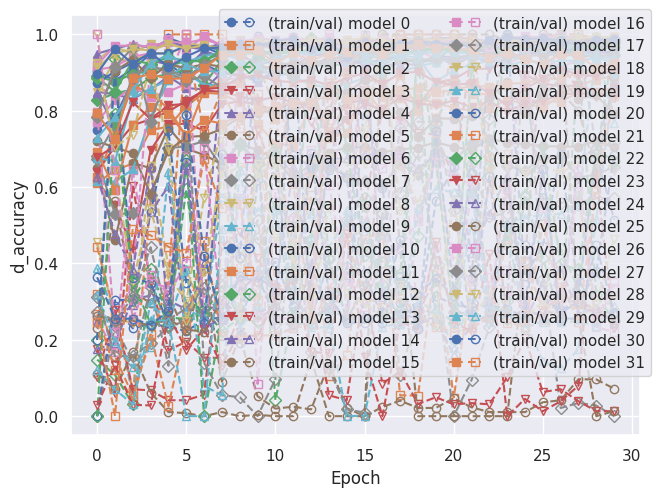

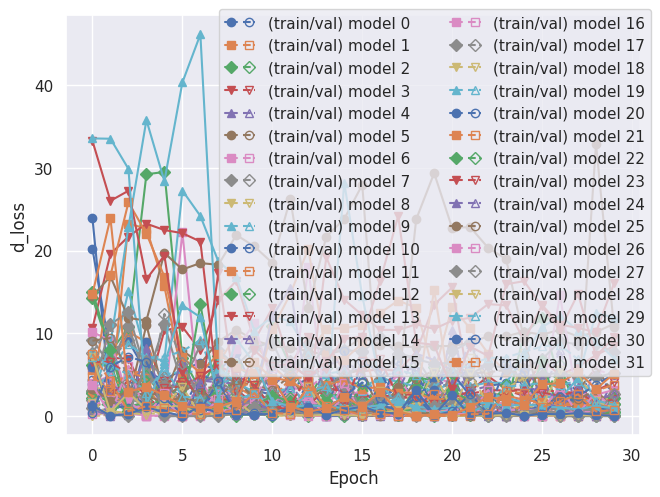

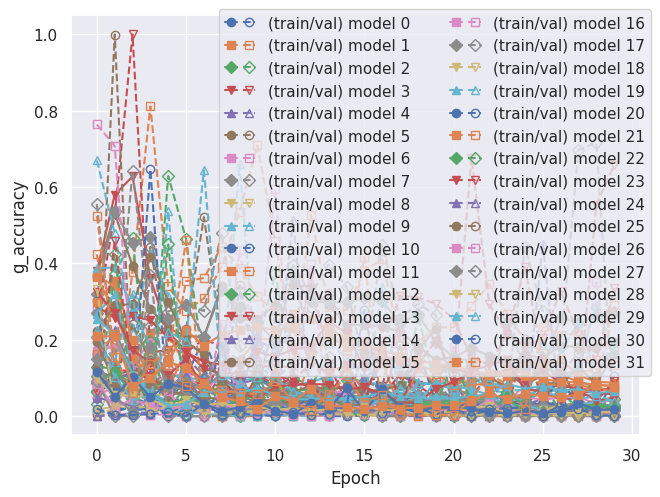

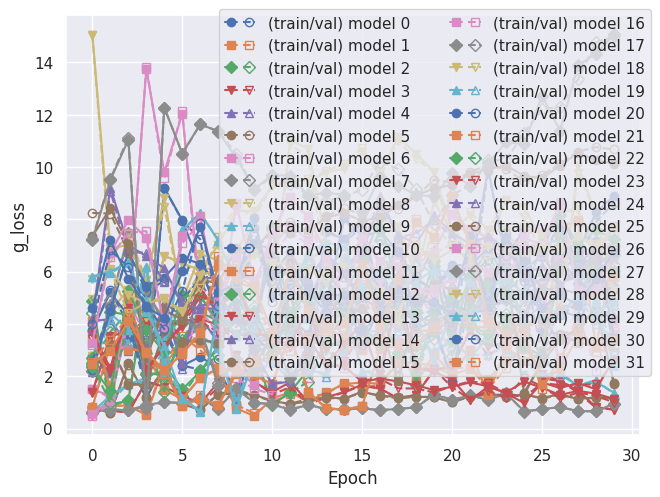

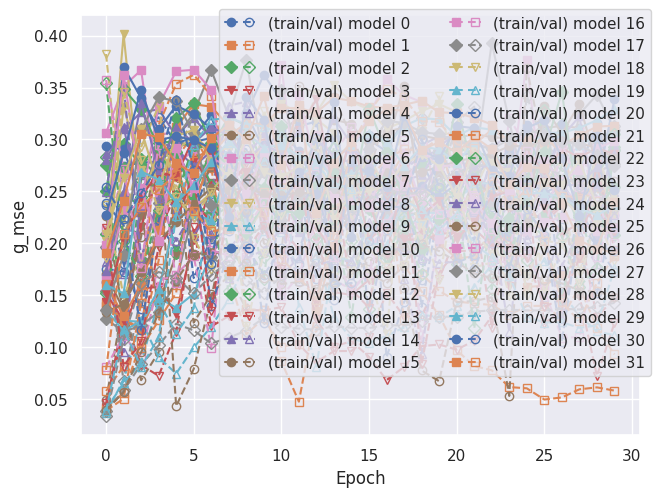

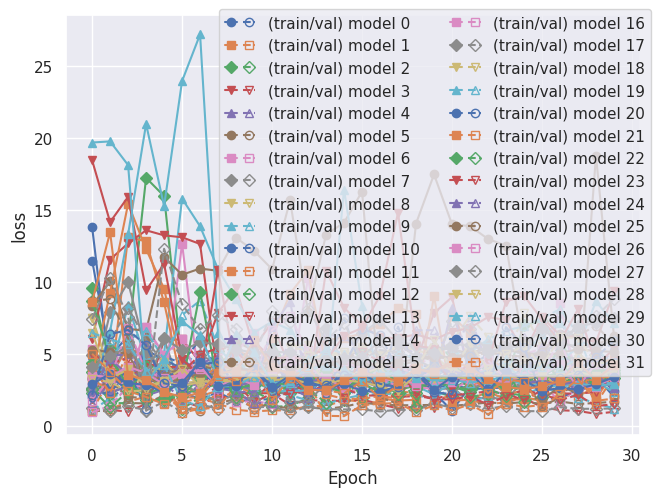

In [28]:
plot_hypertune_histories(histories)

## Data Visualization Examples

In [ ]:
def plot(
    n: np.ndarray,
    s: np.ndarray,
    x: np.ndarray,
    fs: float,
    baud: int,
    ):

    plt.figure()

    fig, axd = plt.subplot_mosaic("A;B;C", figsize=(7,12))
    pkey = 'A'
    axd[pkey].plot(n, s, marker='o', markevery=int(fs/baud))
    axd[pkey].set_title('Data')

    pkey = 'B'
    axd[pkey].plot(n, np.real(x), label='real')
    axd[pkey].plot(n, np.imag(x), label='imag')
    axd[pkey].set_title('Signal')
    axd[pkey].legend()

    pkey = 'C'
    axd[pkey].plot(np.real(x.round(10)), np.imag(x.round(10)), '.')
    axd[pkey].set_title('Constellation')
    axd[pkey].grid(True)

    return fig

<Figure size 640x480 with 0 Axes>

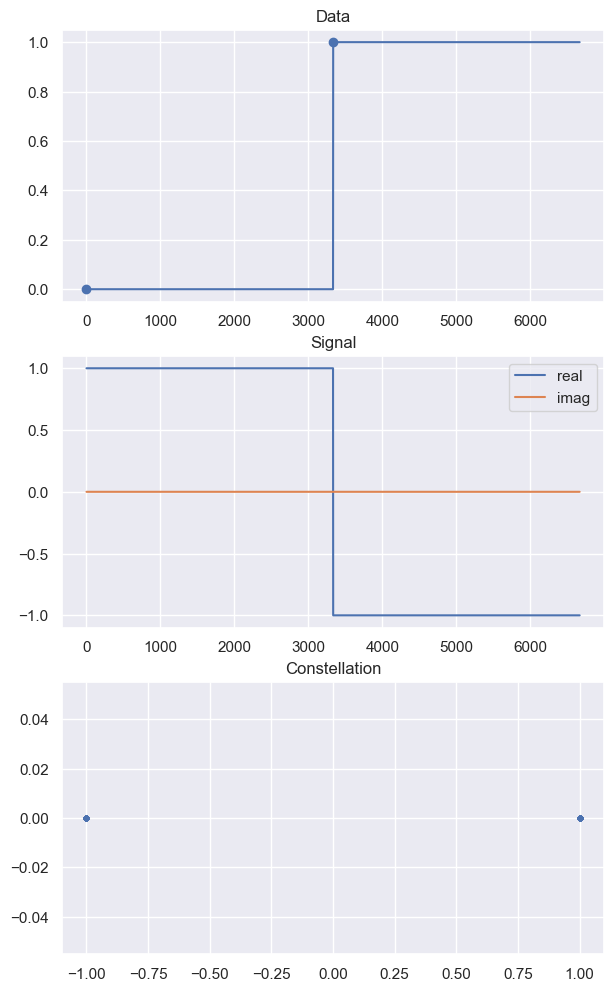

In [ ]:
data, params = load_data(roots['dataset']/"bpsk")
fig = plot(
    n=data['n'],
    s=data['s'],
    x=data['x'],
    fs=params['fs'],
    baud=params['baud'],
)

<Figure size 640x480 with 0 Axes>

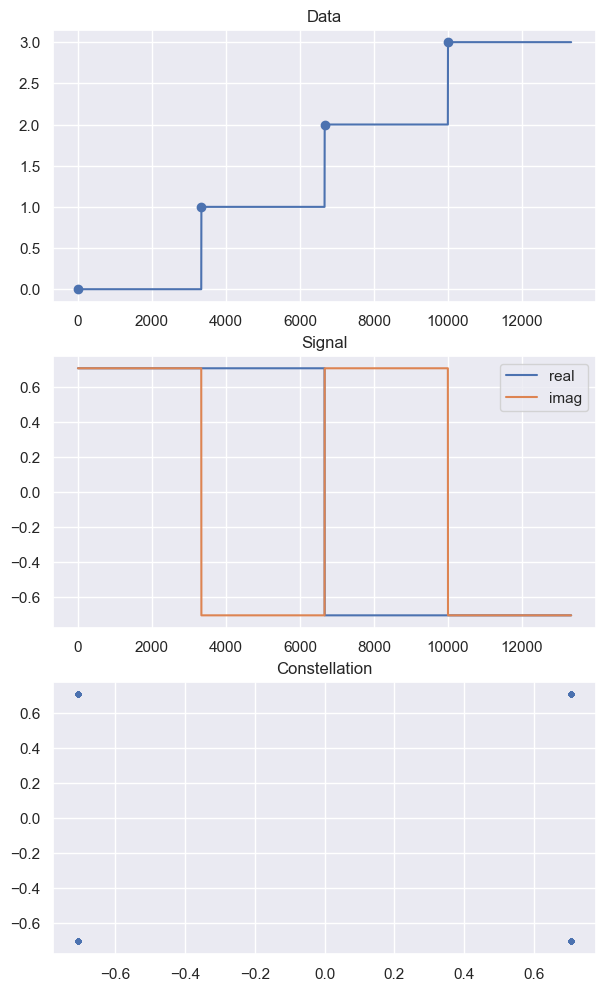

In [ ]:
data, params = load_data(roots['dataset']/"qpsk")
fig = plot(
    n=data['n'],
    s=data['s'],
    x=data['x'],
    fs=params['fs'],
    baud=params['baud'],
)

<Figure size 640x480 with 0 Axes>

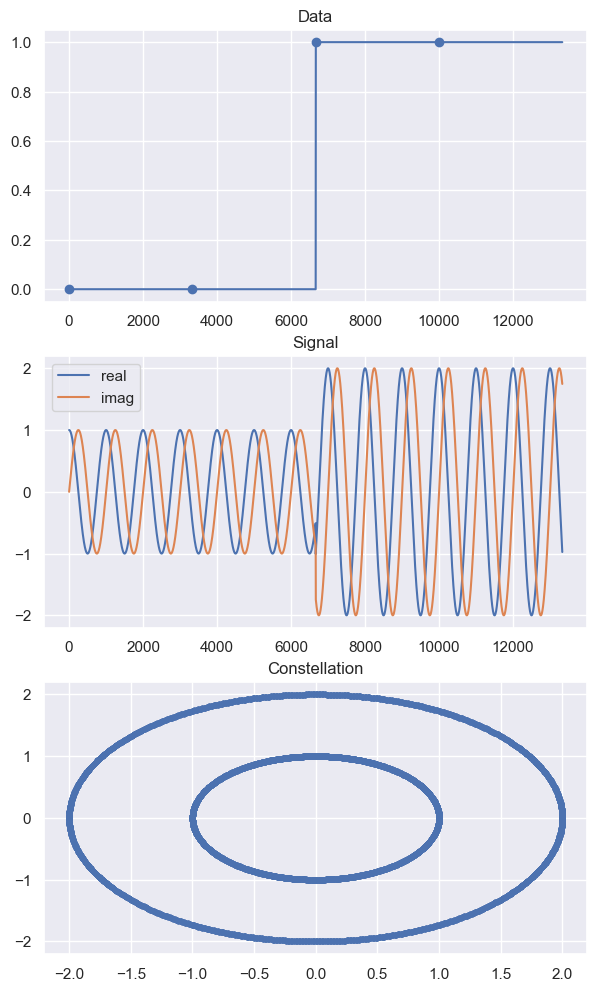

In [ ]:
data, params = load_data(roots['dataset']/"2-ask")
fig = plot(
    n=data['n'],
    s=data['s'],
    x=data['x'],
    fs=params['fs'],
    baud=params['baud'],
)

<Figure size 640x480 with 0 Axes>

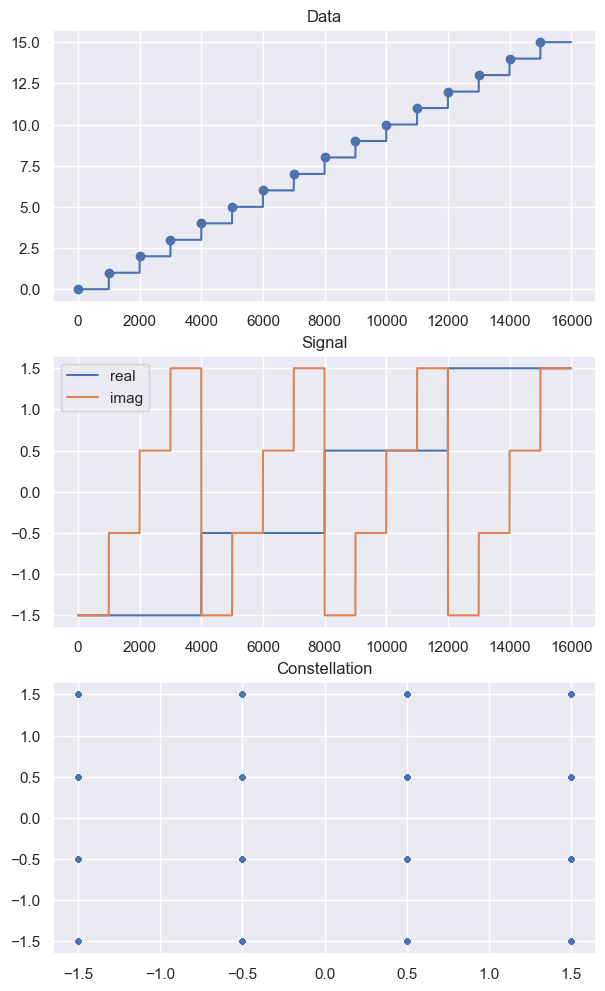

In [ ]:
data, params = load_data(roots['dataset']/"16-qam")
fig = plot(
    n=data['n'],
    s=data['s'],
    x=data['x'],
    fs=params['fs'],
    baud=params['baud'],
)

<Figure size 640x480 with 0 Axes>

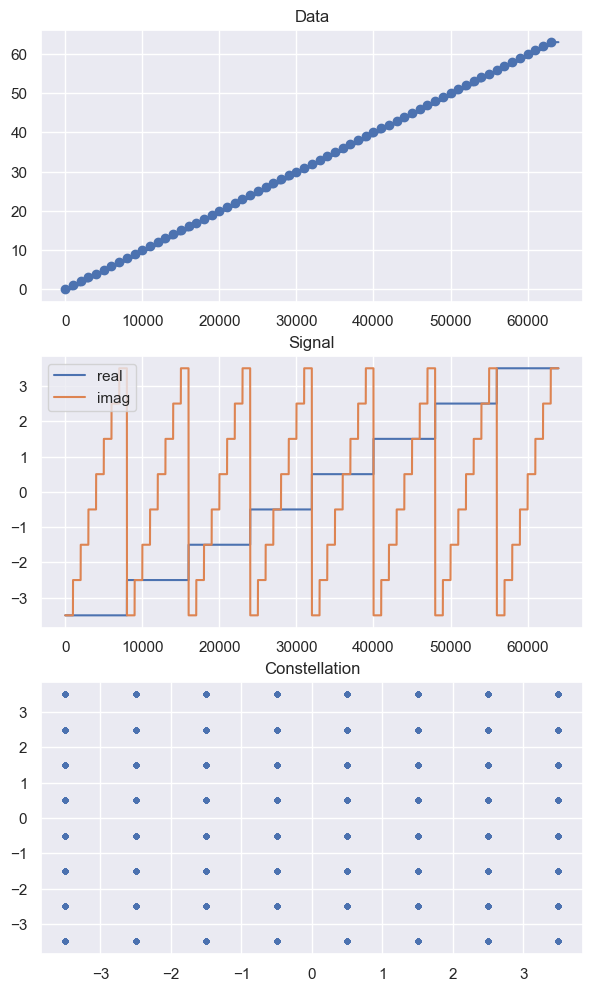

In [ ]:
data, params = load_data(roots['dataset']/"64-qam")
fig = plot(
    n=data['n'],
    s=data['s'],
    x=data['x'],
    fs=params['fs'],
    baud=params['baud'],
)

<Figure size 640x480 with 0 Axes>

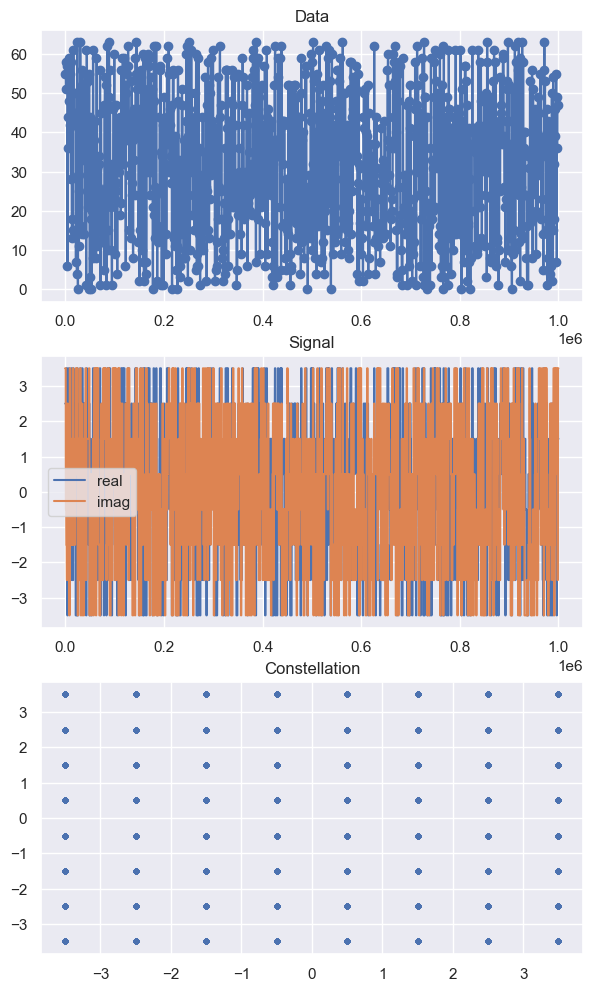

In [ ]:
data, params = load_data(roots['dataset']/"64-qam-long")
fig = plot(
    n=data['n'],
    s=data['s'],
    x=data['x'],
    fs=params['fs'],
    baud=params['baud'],
)